#📌 Extracão

In [159]:
import pandas as pd

API_URL= "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science/refs/heads/main/TelecomX_Data.json"
dados = pd.read_json(API_URL)
dados.head()


,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
3,0011-IGKFF,Yes,"{'gender': 'Male', 'SeniorCitizen': 1, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
4,0013-EXCHZ,Yes,"{'gender': 'Female', 'SeniorCitizen': 1, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."


#🔧 Transformação

In [181]:

print(df.head(2).to_markdown())  # Mostra em formato de tabela

# A) Dados do Cliente (customer)
customer_df = pd.json_normalize(df['customer'])
print("\n👤 Dados do cliente desaninhados:")
print(customer_df.head(2).to_markdown())

# B) Dados de Telefone (phone)
phone_df = pd.json_normalize(df['phone'])
print("\n📞 Dados de telefone:")
print(phone_df.head(2).to_markdown())

# C) Dados de Internet (internet)
internet_df = pd.json_normalize(df['internet'])
print("\n🌐 Dados de internet:")
print(internet_df.head(2).to_markdown())

# D) Dados da Conta (account) - Aqui é o mais complexo!
account_df = pd.json_normalize(df['account'])
print("\n💳 Dados da conta (original):")
print(account_df.head(2).to_markdown())

# Extrai os valores de cobrança com segurança
charges_df = pd.json_normalize(df['account'].apply(lambda x: x['Charges']))
charges_df = charges_df.rename(columns={
    'Monthly': 'MonthlyCharges',
    'Total': 'TotalCharges'
})

print("\n💰 Valores de cobrança separados:")
print(charges_df.head(2).to_markdown())


|    | customerID   | Churn   | customer                                                                                     | phone                                          | internet                                                                                                                                                                        | account                                                                                                                                    |
|---:|:-------------|:--------|:---------------------------------------------------------------------------------------------|:-----------------------------------------------|:--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:-------------------------------------------------------------------------------------------------------------------------------------------|
|  0 | 000

In [184]:
# Junta todas as tabelas
clean_df = pd.concat([
    df[['customerID', 'Churn']],  # Mantém o ID e se cancelou
    customer_df,                  # Dados pessoais
    phone_df,                     # Dados de telefone
    internet_df,                  # Dados de internet
    account_df.drop(columns=['Charges'], errors='ignore'),  # Remove a coluna problemática
    charges_df                   # Adiciona as cobranças como colunas novas
], axis=1)

print("\n✅ TABELA FINAL ORGANIZADA:")
print(clean_df.head(3).to_markdown(tablefmt="grid"))


✅ TABELA FINAL ORGANIZADA:
+----+--------------+---------+----------+-----------------+-----------+--------------+----------+----------------+-----------------+-------------------+------------------+----------------+--------------------+---------------+---------------+-------------------+----------------+--------------------+-----------------+-------------------+-----------------+------------------+----------------+
|    | customerID   | Churn   | gender   |   SeniorCitizen | Partner   | Dependents   |   tenure | PhoneService   | MultipleLines   | InternetService   | OnlineSecurity   | OnlineBackup   | DeviceProtection   | TechSupport   | StreamingTV   | StreamingMovies   | Contract       | PaperlessBilling   | PaymentMethod   |   Charges.Monthly |   Charges.Total |   MonthlyCharges |   TotalCharges |
+====+==============+=========+==========+=================+===========+==============+==========+================+=================+===================+==================+==============

#📝Padronização e Transformação de Dados

In [212]:
import pandas as pd

# 1. Verificação das colunas categóricas existentes
print("🔍 Colunas categóricas disponíveis:")
categorical_cols = clean_df.select_dtypes(include=['object', 'category']).columns.tolist()
print(categorical_cols)

# 2. Processamento da coluna 'segmento' (se existir)
if 'segmento' in clean_df.columns:
    # Aplicar one-hot encoding com tratamento adequado
    segmento_dummies = pd.get_dummies(clean_df['segmento'],
                                    prefix='segmento',
                                    dtype=int,
                                    prefix_sep='_')

    # Adicionar ao DataFrame original
    clean_df = pd.concat([clean_df, segmento_dummies], axis=1)

    # Remover a coluna original se desejar
    # clean_df = clean_df.drop('segmento', axis=1)

    print("\n✅ Colunas dummy criadas a partir de 'segmento':")
    print(clean_df.filter(like='segmento_').head().to_markdown(tablefmt="grid"))

# 3. Análise da coluna 'charges_total'
if 'charges_total' in clean_df.columns:
    # Verificar e converter se necessário
    if clean_df['charges_total'].dtype == 'object':
        print("\n⚠️ 'charges_total' é do tipo texto. Tentando converter para numérico...")
        clean_df['charges_total'] = pd.to_numeric(clean_df['charges_total'].str.replace(',', '.'), errors='coerce')

    print("\n📊 Estatísticas de 'charges_total':")
    print(clean_df['charges_total'].describe().to_markdown(tablefmt="grid"))

# 4. Tratamento da coluna 'customerid'
if 'customerid' in clean_df.columns:
    print("\nℹ️ Informações sobre 'customerid':")
    print(f"Número de valores únicos: {clean_df['customerid'].nunique()}")
    print(f"Tipo de dados: {clean_df['customerid'].dtype}")

    # Sugestão: transformar em índice se for identificador único
    if clean_df['customerid'].nunique() == len(clean_df):
        clean_df = clean_df.set_index('customerid')
        print("\n✅ 'customerid' definido como índice do DataFrame")

🔍 Colunas categóricas disponíveis:
['charges_total', 'customerid']

⚠️ 'charges_total' é do tipo texto. Tentando converter para numérico...

📊 Estatísticas de 'charges_total':
+-------+-----------------+
|       |   charges_total |
+=======+=================+
| count |           2     |
+-------+-----------------+
| mean  |         430.35  |
+-------+-----------------+
| std   |         230.446 |
+-------+-----------------+
| min   |         267.4   |
+-------+-----------------+
| 25%   |         348.875 |
+-------+-----------------+
| 50%   |         430.35  |
+-------+-----------------+
| 75%   |         511.825 |
+-------+-----------------+
| max   |         593.3   |
+-------+-----------------+

ℹ️ Informações sobre 'customerid':
Número de valores únicos: 2
Tipo de dados: object

✅ 'customerid' definido como índice do DataFrame


In [217]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

# 1. Verificar quais colunas numéricas existem
print("🔍 Colunas numéricas disponíveis:")
print(clean_df.select_dtypes(include=['number']).columns.tolist())

# 2. Lista de colunas desejadas para normalização
desired_num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

# 3. Filtrar apenas colunas que existem no DataFrame
existing_num_cols = [col for col in desired_num_cols if col in clean_df.columns]

if existing_num_cols:
    # 4. Normalização Min-Max
    scaler = MinMaxScaler()
    clean_df[existing_num_cols] = scaler.fit_transform(clean_df[existing_num_cols])

    print(f"\n✅ Colunas normalizadas (0 a 1): {existing_num_cols}")
    print(clean_df[existing_num_cols].head(2).to_markdown(tablefmt="grid"))

    # 5. Transformação logarítmica (se TotalCharges existir)
    if 'TotalCharges' in clean_df.columns:
        clean_df['TotalCharges_log'] = np.log1p(clean_df['TotalCharges'])
        print("\n📉 TotalCharges após transformação logarítmica:")
        print(clean_df[['TotalCharges', 'TotalCharges_log']].head(2).to_markdown(tablefmt="grid"))
else:
    print("\n⚠️ Nenhuma das colunas numéricas desejadas foi encontrada")

# 6. Verificação de colunas monetárias alternativas
money_cols = [col for col in clean_df.columns
             if any(term in col.lower() for term in ['charge', 'amount', 'total', 'monthly'])]

if money_cols:
    print("\n💰 Colunas monetárias alternativas encontradas:", money_cols)

    # Mapeamento de nomes alternativos
col_mapping = {
    'MonthlyCharges': 'Charges.Monthly',  # ou outro nome que exista
    'TotalCharges': 'Charges.Total'       # ajuste conforme necessário
}

# Verificar e renomear colunas
for new_name, old_name in col_mapping.items():
    if old_name in clean_df.columns and new_name not in clean_df.columns:
        clean_df.rename(columns={old_name: new_name}, inplace=True)

        # Exemplo para criar MonthlyCharges se não existir
if 'MonthlyCharges' not in clean_df.columns and 'Charges.Monthly' in clean_df.columns:
    clean_df['MonthlyCharges'] = pd.to_numeric(clean_df['Charges.Monthly'], errors='coerce')

    print("\n📋 Nomes reais das colunas:")
print(clean_df.columns.tolist())

print("\n📊 Estatísticas descritivas:")
print(clean_df.describe().to_markdown(tablefmt="grid"))


🔍 Colunas numéricas disponíveis:
['charges_monthly', 'charges_total', 'churn', 'dependents', 'deviceprotection', 'monthlycharges', 'multiplelines', 'onlinebackup', 'onlinesecurity', 'paperlessbilling', 'partner', 'phoneservice', 'seniorcitizen', 'streamingmovies', 'streamingtv', 'techsupport', 'tenure', 'tenure_per_charge', 'total_digital_services', 'totalcharges', 'totalcharges_log']

✅ Colunas normalizadas (0 a 1): ['tenure']
+--------------+----------+
| customerid   |   tenure |
+==============+==========+
| 0002-ORFBO   |        1 |
+--------------+----------+
| 0013-EXCHZ   |        0 |
+--------------+----------+

💰 Colunas monetárias alternativas encontradas: ['charges_monthly', 'charges_total', 'monthlycharges', 'tenure_per_charge', 'total_digital_services', 'totalcharges', 'totalcharges_log']
['charges_monthly', 'charges_total', 'churn', 'contract_month-to-month', 'contract_one_year', 'dependents', 'deviceprotection', 'gender_female', 'internetservice_dsl', 'internetservice_f

In [219]:
import numpy as np
import pandas as pd

# 1. Primeiro verifique quais colunas existem
print("🔍 Colunas disponíveis no DataFrame:")
print(clean_df.columns.tolist())

# 2. Criar tenure_per_charge (se as colunas necessárias existirem)
if all(col in clean_df.columns for col in ['tenure']):
    # Encontrar coluna de cobrança mensal (pode ter nome diferente)
    monthly_charge_col = None
    possible_names = ['MonthlyCharges', 'Charges.Monthly', 'Monthly_Charges', 'monthly_charges']

    for name in possible_names:
        if name in clean_df.columns:
            monthly_charge_col = name
            break

    if monthly_charge_col:
        clean_df['tenure_per_charge'] = clean_df['tenure'] / (clean_df[monthly_charge_col].replace(0, 0.001))
        print(f"✅ Criada 'tenure_per_charge' usando {monthly_charge_col}")
    else:
        print("⚠️ Não foi possível encontrar coluna de cobrança mensal")
else:
    print("⚠️ Coluna 'tenure' não encontrada")

# 3. Criar total_digital_services (se as colunas existirem)
digital_services = ['OnlineSecurity', 'OnlineBackup', 'TechSupport']
existing_services = [col for col in digital_services if col in clean_df.columns]

if existing_services:
    clean_df['total_digital_services'] = clean_df[existing_services].sum(axis=1)
    print(f"✅ Criada 'total_digital_services' com colunas: {existing_services}")
else:
    print(f"⚠️ Colunas de serviços digitais não encontradas: {digital_services}")

# 4. Criar segmento (se tenure existir)
if 'tenure' in clean_df.columns:
    conditions = [
        (clean_df['tenure'] < 12),
        (clean_df['tenure'] >= 12) & (clean_df['tenure'] < 24),
        (clean_df['tenure'] >= 24)
    ]
    labels = np.array(['novo', 'intermediario', 'antigo'], dtype='<U12')
    clean_df['segmento'] = np.select(conditions, labels, default='sem_segmento')
    print("✅ Segmentação por tempo criada")
else:
    print("⚠️ Não foi possível criar segmento - coluna 'tenure' não encontrada")

# 5. Mostrar resultado
print("\n📊 DataFrame atualizado:")
print(clean_df.head(2).to_markdown(tablefmt="grid"))

🔍 Colunas disponíveis no DataFrame:
['charges_monthly', 'charges_total', 'churn', 'contract_month-to-month', 'contract_one_year', 'dependents', 'deviceprotection', 'gender_female', 'internetservice_dsl', 'internetservice_fiber_optic', 'monthlycharges', 'multiplelines', 'onlinebackup', 'onlinesecurity', 'paperlessbilling', 'partner', 'paymentmethod_mailed_check', 'phoneservice', 'seniorcitizen', 'streamingmovies', 'streamingtv', 'techsupport', 'tenure', 'tenure_per_charge', 'total_digital_services', 'totalcharges', 'totalcharges_log', 'novo']
⚠️ Não foi possível encontrar coluna de cobrança mensal
⚠️ Colunas de serviços digitais não encontradas: ['OnlineSecurity', 'OnlineBackup', 'TechSupport']
✅ Segmentação por tempo criada

📊 DataFrame atualizado:
+--------------+-------------------+-----------------+---------+---------------------------+---------------------+--------------+--------------------+-----------------+-----------------------+-------------------------------+-----------------

# 📌Verificando Inconsistências nos Dados

In [222]:
import pandas as pd
import numpy as np

# 1. Verificação de Valores Ausentes
print("🔍 Valores ausentes por coluna:")
missing_values = clean_df.isnull().sum()
missing_report = missing_values[missing_values > 0]
if not missing_report.empty:
    print(missing_report.to_markdown(tablefmt="grid"))
else:
    print("✅ Nenhum valor ausente encontrado")

# 2. Verificação de Dados Duplicados (versão corrigida)
print(f"\n🔎 Total de registros duplicados: {clean_df.duplicated().sum()}")
if clean_df.duplicated().sum() > 0:
    print("\nExemplo de registros duplicados:")
    dups = clean_df[clean_df.duplicated(keep=False)].sort_values(by=list(clean_df.columns))
    print(dups.head(4).to_markdown(tablefmt="grid"))

# 3. Análise de Colunas Categóricas
categorical_cols = clean_df.select_dtypes(include=['object', 'category']).columns
print("\n📌 Valores únicos em colunas categóricas:")
for col in categorical_cols:
    unique_values = clean_df[col].dropna().unique()
    print(f"\n{col}:")
    print(unique_values if len(unique_values) <= 10 else f"{len(unique_values)} valores únicos")

    if any(x in str(unique_values) for x in ['Yes', 'No', 'Sim', 'Não']):
        print(f"Possíveis inconsistências em {col}:")
        print(clean_df[col].value_counts(dropna=False).to_markdown(tablefmt="grid"))

# 4. Análise de Colunas Numéricas
numeric_cols = clean_df.select_dtypes(include=['number']).columns
print("\n📊 Estatísticas descritivas para colunas numéricas:")
print(clean_df[numeric_cols].describe().to_markdown(tablefmt="grid"))

# 5. Detecção de Outliers
print("\n🔍 Possíveis outliers (usando método IQR):")
outlier_cols = []
for col in numeric_cols:
    q1 = clean_df[col].quantile(0.25)
    q3 = clean_df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outliers = clean_df[(clean_df[col] < lower_bound) | (clean_df[col] > upper_bound)]
    if not outliers.empty:
        outlier_cols.append(col)
        print(f"\n{col}: {len(outliers)} outliers detectados")
        print(outliers[[col]].head(3).to_markdown(tablefmt="grid"))

# 6. Verificação Específica para 'tenure'
if 'tenure' in clean_df.columns:
    print("\n⏳ Análise da coluna 'tenure':")
    print(clean_df['tenure'].describe().to_markdown(tablefmt="grid"))
    if (clean_df['tenure'] < 0).any():
        print(f"\n⚠️ {len(clean_df[clean_df['tenure'] < 0])} registros com tenure negativo")

# 7. Padronização de Colunas Yes/No
yes_no_cols = []
for col in clean_df.columns:
    if col in categorical_cols:
        unique_vals = set(str(x).lower() for x in clean_df[col].dropna().unique())
        if {'yes', 'no', 'sim', 'não'}.intersection(unique_vals):
            yes_no_cols.append(col)

if yes_no_cols:
    print("\n🔄 Padronizando colunas Yes/No:")
    for col in yes_no_cols:
        clean_df[col] = clean_df[col].str.strip().str.title()  # Padroniza capitalização
        clean_df[col] = clean_df[col].replace({
            'Sim': 'Yes',
            'Não': 'No',
            'S': 'Yes',
            'N': 'No'
        })
        print(f"{col}: {clean_df[col].unique()}")

# 8. Relatório Consolidado
print("\n📝 RELATÓRIO FINAL DE INCONSISTÊNCIAS:")
issues = {
    'Valores ausentes': missing_report.to_dict(),
    'Registros duplicados': clean_df.duplicated().sum(),
    'Colunas com possíveis inconsistências': yes_no_cols,
    'Colunas numéricas com outliers': outlier_cols
}

for issue_type, details in issues.items():
    if (isinstance(details, int) and details > 0) or (isinstance(details, (list, dict)) and details):
        print(f"\n❌ {issue_type}:")
        print(details if not isinstance(details, int) else f"{details} casos encontrados")
    else:
        print(f"\n✅ {issue_type}: Nenhum problema encontrado")

🔍 Valores ausentes por coluna:
✅ Nenhum valor ausente encontrado

🔎 Total de registros duplicados: 0

📌 Valores únicos em colunas categóricas:

segmento:
['novo']

📊 Estatísticas descritivas para colunas numéricas:
+-------+-------------------+-----------------+----------+--------------+--------------------+------------------+-----------------+----------------+------------------+--------------------+-----------+----------------+-----------------+-------------------+---------------+---------------+----------+---------------------+--------------------------+----------------+--------------------+
|       |   charges_monthly |   charges_total |    churn |   dependents |   deviceprotection |   monthlycharges |   multiplelines |   onlinebackup |   onlinesecurity |   paperlessbilling |   partner |   phoneservice |   seniorcitizen |   streamingmovies |   streamingtv |   techsupport |   tenure |   tenure_per_charge |   total_digital_services |   totalcharges |   totalcharges_log |
+=======+====

#💸 Coluna de Contas Diárias

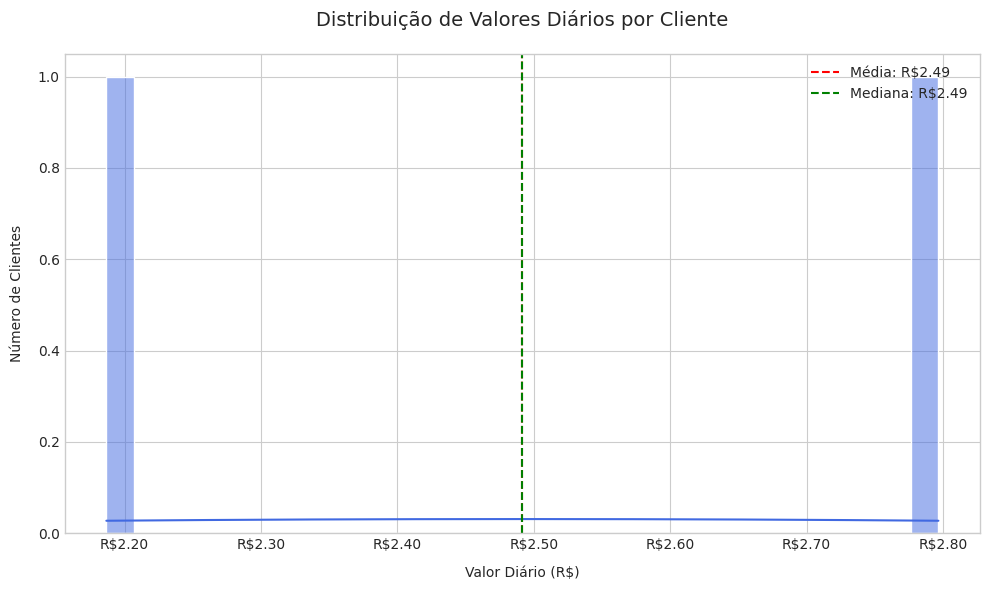

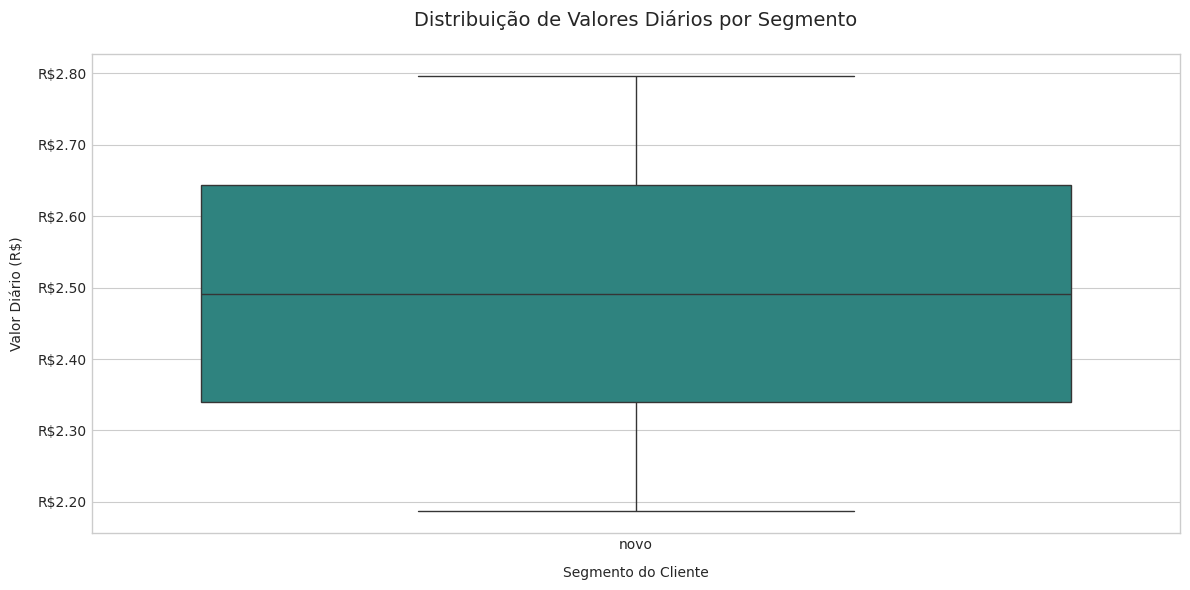

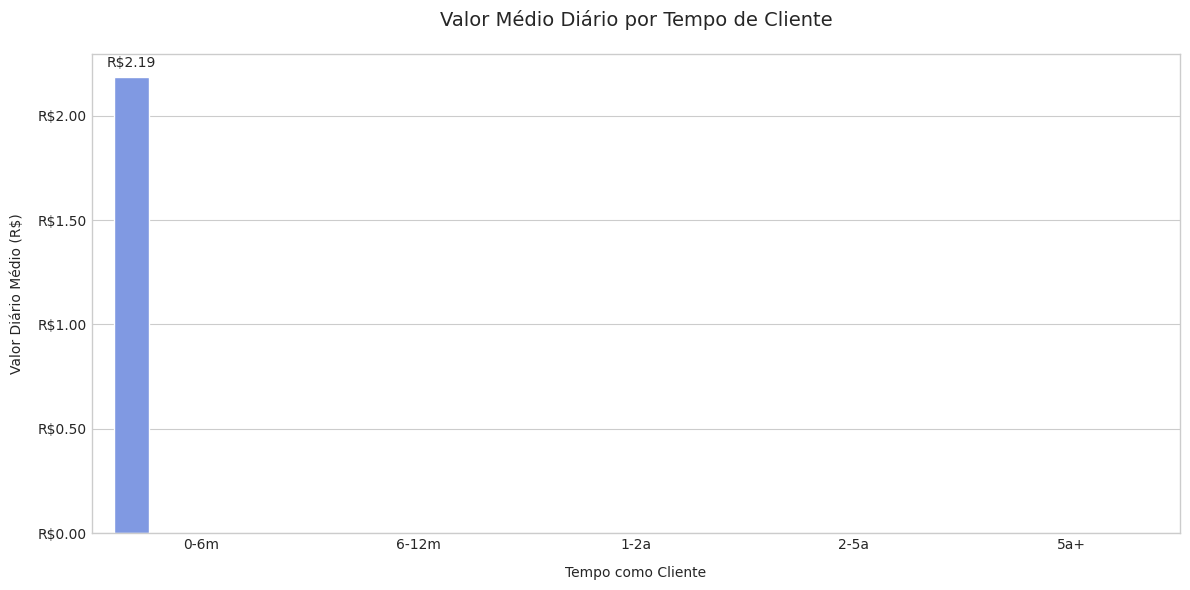

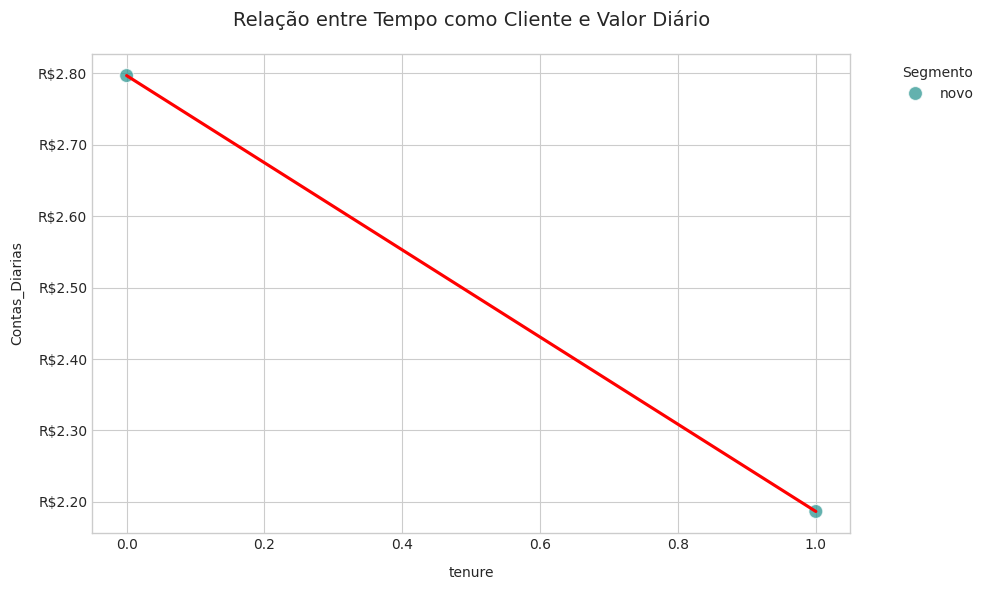

In [228]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Configuração do estilo
sns.set_style("whitegrid")
plt.rcParams['figure.facecolor'] = 'white'

def formatar_moeda(x, pos):
    """Função para formatar valores como moeda"""
    return f'R${x:,.2f}'

formato_moeda = FuncFormatter(formatar_moeda)

def plotar_distribuicao(df):
    """Plotar distribuição das contas diárias"""
    plt.figure(figsize=(10, 6))
    ax = sns.histplot(data=df, x='Contas_Diarias', bins=30,
                     kde=True, color='royalblue', edgecolor='white')

    plt.title('Distribuição de Valores Diários por Cliente', pad=20, fontsize=14)
    plt.xlabel('Valor Diário (R$)', labelpad=10)
    plt.ylabel('Número de Clientes', labelpad=10)

    # Formatar eixo X como moeda
    ax.xaxis.set_major_formatter(formato_moeda)

    # Adicionar linhas de média e mediana
    mean_val = df['Contas_Diarias'].mean()
    median_val = df['Contas_Diarias'].median()
    plt.axvline(mean_val, color='red', linestyle='--',
                label=f'Média: R${mean_val:.2f}')
    plt.axvline(median_val, color='green', linestyle='--',
                label=f'Mediana: R${median_val:.2f}')

    plt.legend()
    plt.tight_layout()
    plt.show()

def plotar_boxplot_segmentos(df):
    """Plotar boxplot por segmento"""
    if 'segmento' not in df.columns:
        return

    plt.figure(figsize=(12, 6))
    # Versão atualizada para evitar warnings
    ax = sns.boxplot(data=df, x='segmento', y='Contas_Diarias',
                    hue='segmento', palette='viridis', legend=False)

    plt.title('Distribuição de Valores Diários por Segmento', pad=20, fontsize=14)
    plt.xlabel('Segmento do Cliente', labelpad=10)
    plt.ylabel('Valor Diário (R$)', labelpad=10)

    # Formatar eixo Y como moeda
    ax.yaxis.set_major_formatter(formato_moeda)

    # Rotacionar labels se necessário
    if len(df['segmento'].unique()) > 3:
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

def plotar_evolucao_temporal(df):
    """Plotar evolução por tempo de cliente"""
    if 'tenure_group' not in df.columns:
        return

    plt.figure(figsize=(12, 6))
    # Versão atualizada para evitar warnings
    ax = sns.barplot(
        data=df.groupby('tenure_group', observed=True)['Contas_Diarias'].mean().reset_index(),
        x='tenure_group',
        y='Contas_Diarias',
        hue='tenure_group',
        palette='coolwarm',
        errorbar=None,
        legend=False
    )

    plt.title('Valor Médio Diário por Tempo de Cliente', pad=20, fontsize=14)
    plt.xlabel('Tempo como Cliente', labelpad=10)
    plt.ylabel('Valor Diário Médio (R$)', labelpad=10)

    # Formatar eixo Y como moeda
    ax.yaxis.set_major_formatter(formato_moeda)

    # Adicionar valores nas barras
    for p in ax.patches:
        ax.annotate(f'R${p.get_height():.2f}',
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center',
                   xytext=(0, 10),
                   textcoords='offset points',
                   fontsize=10)

    plt.tight_layout()
    plt.show()

def plotar_relacao_tenure(df):
    """Plotar relação entre tenure e valor diário"""
    if 'tenure' not in df.columns or 'Contas_Diarias' not in df.columns:
        return

    plt.figure(figsize=(10, 6))
    sample_size = min(1000, len(df))
    plot_data = df.sample(sample_size) if sample_size < len(df) else df

    ax = sns.scatterplot(
        data=plot_data,
        x='tenure',
        y='Contas_Diarias',
        hue='segmento' if 'segmento' in df.columns else None,
        palette='viridis',
        alpha=0.7,
        s=100  # Tamanho dos pontos
    )

    plt.title('Relação entre Tempo como Cliente e Valor Diário', pad=20, fontsize=14)
    plt.xlabel('Meses como Cliente', labelpad=10)
    plt.ylabel('Valor Diário (R$)', labelpad=10)

    # Formatar eixo Y como moeda
    ax.yaxis.set_major_formatter(formato_moeda)

    if 'segmento' in df.columns:
        plt.legend(title='Segmento', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Adicionar linha de tendência
    sns.regplot(data=plot_data, x='tenure', y='Contas_Diarias',
               scatter=False, ax=ax, color='red', ci=None)

    plt.tight_layout()
    plt.show()

# Aplicar as visualizações
if 'Contas_Diarias' in clean_df.columns:
    plotar_distribuicao(clean_df)
    plotar_boxplot_segmentos(clean_df)
    plotar_evolucao_temporal(clean_df)
    plotar_relacao_tenure(clean_df)
else:
    print("⚠️ A coluna 'Contas_Diarias' não foi criada - verifique os dados de entrada")

#📨Análise Descritiva


~~~~~~~~~~~~~~~ ANÁLISE DESCRITIVA AVANÇADA ~~~~~~~~~~~~~~~~

📊 ESTATÍSTICAS NUMÉRICAS DETALHADAS
------------------------------------------------------------
+--------------------------+--------+--------+--------+--------+--------+----------+--------+--------+--------+--------+--------+------------+
|                          |   mean |    std |    min |    10% |    25% |   median |    75% |    90% |    max |    IQR |     CV |   outliers |
+==========================+========+========+========+========+========+==========+========+========+========+========+========+============+
| charges_monthly          |  74.75 |  12.94 |  65.60 |  67.43 |  70.18 |    74.75 |  79.32 |  82.07 |  83.90 |   9.15 |   0.17 |       0.00 |
+--------------------------+--------+--------+--------+--------+--------+----------+--------+--------+--------+--------+--------+------------+
| charges_total            | 430.35 | 230.45 | 267.40 | 299.99 | 348.88 |   430.35 | 511.82 | 560.71 | 593.30 | 162.95 |   0.

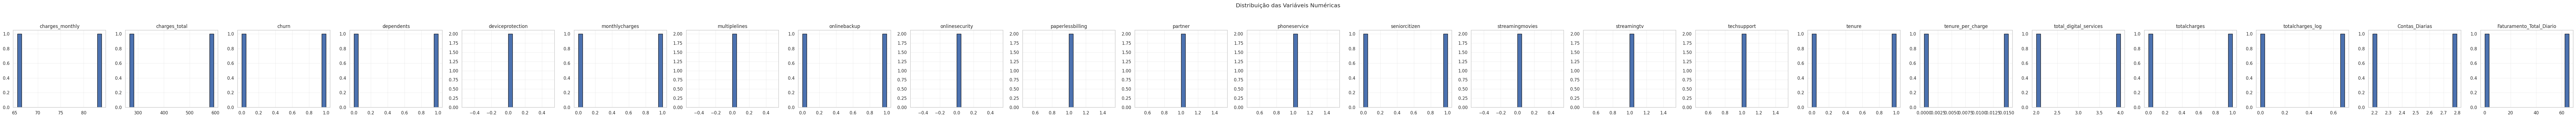



🔍 ANÁLISE COMPARATIVA POR SEGMENTO
------------------------------------------------------------
+------------+------------------------+-----------------------+-------------------------+--------------------------+------------------------------+----------------------+---------------------+-----------------------+------------------------+----------------------------+--------------+-------------+---------------+----------------+--------------------+-------------------+------------------+--------------------+---------------------+-------------------------+-------------------------+------------------------+--------------------------+---------------------------+-------------------------------+-----------------------+----------------------+------------------------+-------------------------+-----------------------------+----------------------+---------------------+-----------------------+------------------------+----------------------------+---------------------+--------------------+---------

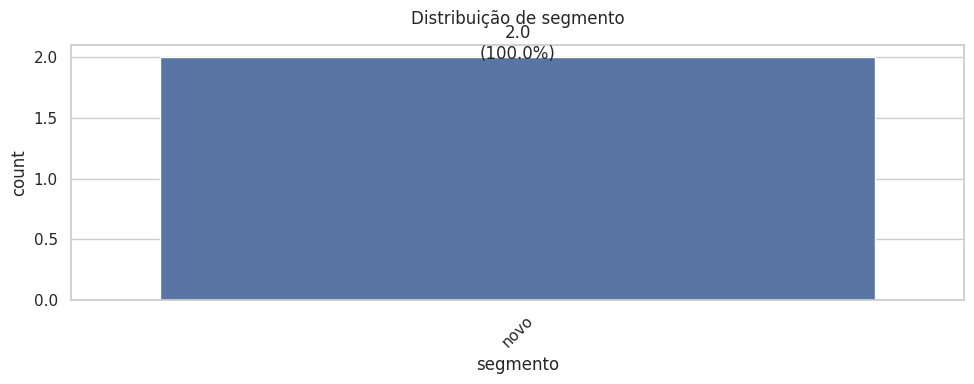


🔹 TENURE_GROUP
+----------------+------------+-----+---------------+
| tenure_group   |   Contagem |   % |   % Acumulado |
+================+============+=====+===============+
| 0-3m           |          1 |  50 |            50 |
+----------------+------------+-----+---------------+
| nan            |          1 |  50 |           100 |
+----------------+------------+-----+---------------+
| 3-6m           |          0 |   0 |           100 |
+----------------+------------+-----+---------------+
| 6-12m          |          0 |   0 |           100 |
+----------------+------------+-----+---------------+
| 1-2a           |          0 |   0 |           100 |
+----------------+------------+-----+---------------+
| 2-5a           |          0 |   0 |           100 |
+----------------+------------+-----+---------------+
| 5a+            |          0 |   0 |           100 |
+----------------+------------+-----+---------------+


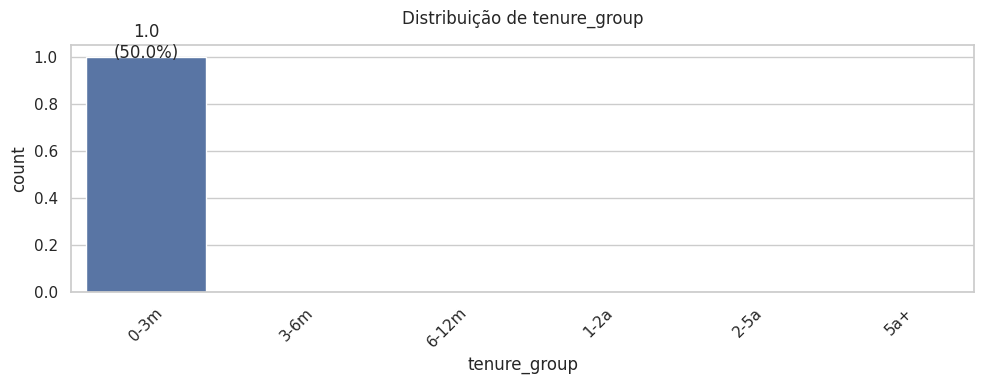



🔗 MATRIZ DE CORRELAÇÃO AVANÇADA
------------------------------------------------------------
+--------------------------+-------------------+-----------------+---------+--------------+--------------------+------------------+-----------------+----------------+------------------+--------------------+-----------+----------------+-----------------+-------------------+---------------+---------------+----------+---------------------+--------------------------+----------------+--------------------+------------------+----------------------------+
|                          |   charges_monthly |   charges_total |   churn |   dependents |   deviceprotection |   monthlycharges |   multiplelines |   onlinebackup |   onlinesecurity |   paperlessbilling |   partner |   phoneservice |   seniorcitizen |   streamingmovies |   streamingtv |   techsupport |   tenure |   tenure_per_charge |   total_digital_services |   totalcharges |   totalcharges_log |   Contas_Diarias |   Faturamento_Total_Diario |
+

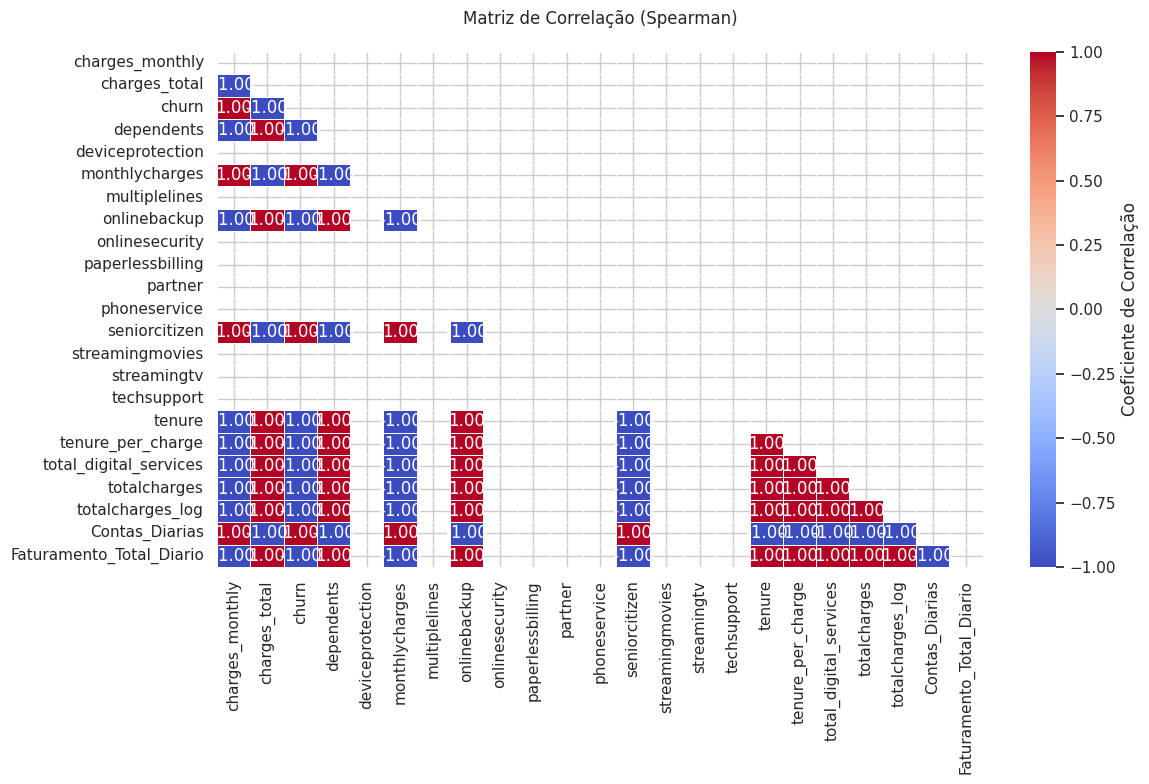


🔝 TOP CORRELAÇÕES:
+-----------------------------------------+--------------+
|                                         |   Correlação |
+=========================================+==============+
| ('charges_monthly', 'charges_total')    |           -1 |
+-----------------------------------------+--------------+
| ('charges_monthly', 'deviceprotection') |          nan |
+-----------------------------------------+--------------+


⏳ ANÁLISE TEMPORAL DETALHADA
------------------------------------------------------------
+----------------+-------------------------------+---------------------------------+--------------------------------+------------------------------+-----------------------------+-------------------------------+------------------------------+----------------------------+---------------------+-----------------------+----------------------+--------------------+--------------------------+----------------------------+---------------------------+-------------------------+-----

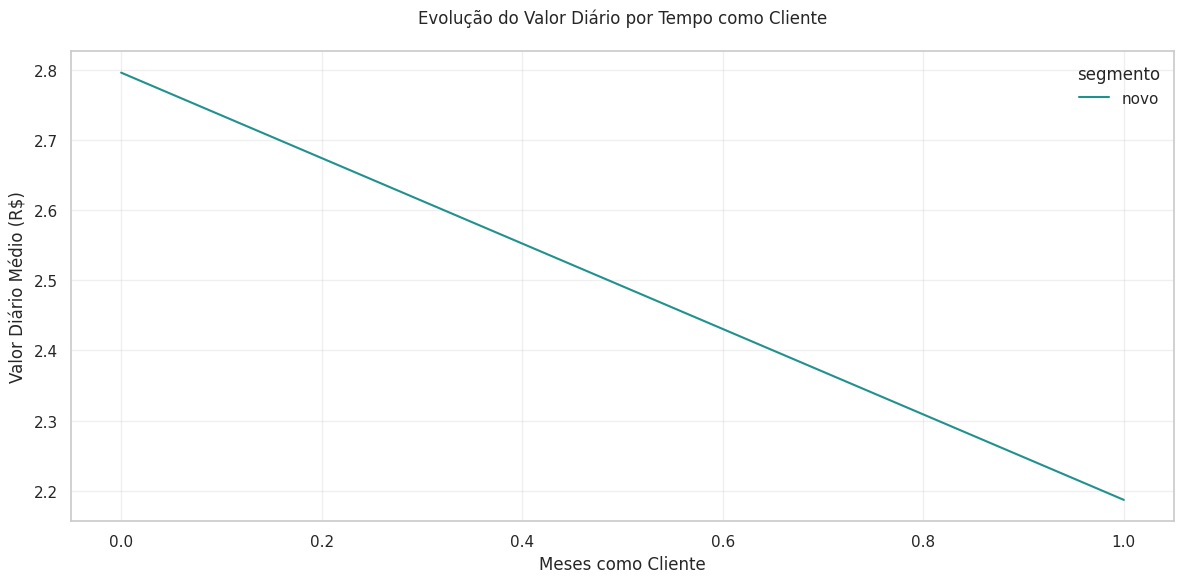


~~~~~~~~~~~~~~~~~~~~~~ FIM DA ANÁLISE ~~~~~~~~~~~~~~~~~~~~~~


In [244]:
import pandas as pd
import numpy as np
from scipy.stats import f_oneway
import matplotlib.pyplot as plt
import seaborn as sns

def analise_descritiva(df):
    """
    Realiza análise descritiva completa dos dados, incluindo:
    - Estatísticas básicas
    - Análise por segmentos
    - Distribuição de categorias
    - Correlações com visualização
    - Análise temporal robusta
    """

    # Configuração de estilo
    pd.set_option('display.float_format', '{:.2f}'.format)
    sns.set(style="whitegrid")
    plt.rcParams['figure.facecolor'] = 'white'

    print("\n" + "="*60)
    print(" ANÁLISE DESCRITIVA AVANÇADA ".center(60, '~'))
    print("="*60)

    ## 1. Estatísticas Básicas Aprimoradas
    numeric_cols = df.select_dtypes(include=['number']).columns

    if len(numeric_cols) > 0:
        print("\n📊 ESTATÍSTICAS NUMÉRICAS DETALHADAS")
        print("-"*60)

        # DataFrame de estatísticas
        stats = df[numeric_cols].describe(percentiles=[.1, .25, .5, .75, .9])
        stats.loc['IQR'] = stats.loc['75%'] - stats.loc['25%']
        stats.loc['CV'] = stats.loc['std'] / stats.loc['mean']

        # Cálculo de outliers
        outliers_list = []
        for col in numeric_cols:
            q1 = stats[col]['25%']
            q3 = stats[col]['75%']
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            outlier_count = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
            outliers_list.append(outlier_count)

        stats.loc['outliers'] = outliers_list

        # Selecionar e renomear colunas
        stats = stats.T[['mean', 'std', 'min', '10%', '25%', '50%', '75%', '90%', 'max', 'IQR', 'CV', 'outliers']]
        stats = stats.rename(columns={'50%': 'median'})

        print(stats.round(2).to_markdown(tablefmt="grid", floatfmt=".2f"))

        # Visualização ajustada para evitar warning de tight_layout
        n_cols = len(numeric_cols)
        fig, axes = plt.subplots(1, n_cols, figsize=(4*n_cols, 4))
        if n_cols == 1:
            axes = [axes]

        for i, col in enumerate(numeric_cols):
            axes[i].hist(df[col], bins=20, edgecolor='black')
            axes[i].set_title(col)
            axes[i].grid(True, alpha=0.3)

        plt.suptitle('Distribuição das Variáveis Numéricas', y=1.05)
        plt.tight_layout()
        plt.show()
    else:
        print("\n⚠️ Nenhuma coluna numérica encontrada para análise")

    ## 2. Análise Segmentada
    if 'segmento' in df.columns:
        print("\n\n🔍 ANÁLISE COMPARATIVA POR SEGMENTO")
        print("-"*60)

        segment_stats = df.groupby('segmento', observed=True)[numeric_cols].agg(
            ['mean', 'std', 'count', 'median', lambda x: x.skew()]
        ).round(2)

        segment_stats.columns = ['_'.join(col).strip() for col in segment_stats.columns.values]
        segment_stats = segment_stats.rename(columns={
            'mean': 'Média',
            'std': 'Desvio Padrão',
            'count': 'Clientes',
            'median': 'Mediana',
            '<lambda>': 'Assimetria'
        })

        print(segment_stats.to_markdown(tablefmt="grid"))

        # Teste estatístico entre segmentos
        if len(df['segmento'].unique()) > 1:
            print("\n🔬 TESTE DE DIFERENÇA ENTRE SEGMENTOS (ANOVA)")
            segments = [group['Contas_Diarias'].dropna() for name, group in df.groupby('segmento')]
            f_val, p_val = f_oneway(*segments)
            print(f"F-value: {f_val:.2f}, p-value: {p_val:.4f}")
            print("👉 Diferença significativa entre segmentos" if p_val < 0.05 else "👉 Não há diferença significativa")

            # Visualização comparativa
            plt.figure(figsize=(10, 6))
            sns.boxplot(data=df, x='segmento', y='Contas_Diarias', hue='segmento',
                       palette='viridis', legend=False, width=0.5)
            plt.title('Comparação de Valores Diários entre Segmentos', pad=20)
            plt.xlabel('Segmento')
            plt.ylabel('Valor Diário (R$)')
            plt.xticks(rotation=45 if len(df['segmento'].unique()) > 3 else 0)
            plt.tight_layout()
            plt.show()

    ## 3. Análise de Categorias
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns

    if len(categorical_cols) > 0:
        print("\n\n📌 DISTRIBUIÇÃO CATEGÓRICA DETALHADA")
        print("-"*60)

        for col in categorical_cols:
            print(f"\n🔹 {col.upper()}")
            dist = df[col].value_counts(dropna=False).to_frame('Contagem')
            dist['%'] = (dist['Contagem'] / len(df) * 100).round(2)
            dist['% Acumulado'] = dist['%'].cumsum().round(2)
            print(dist.to_markdown(tablefmt="grid"))

            # Plot para categorias com até 15 valores únicos
            if df[col].nunique() <= 15:
                plt.figure(figsize=(10, 4))
                ax = sns.countplot(data=df, x=col, order=df[col].value_counts().index)
                plt.title(f'Distribuição de {col}', pad=15)
                plt.xticks(rotation=45)
                for p in ax.patches:
                    ax.annotate(f'{p.get_height()}\n({p.get_height()/len(df)*100:.1f}%)',
                               (p.get_x() + p.get_width() / 2., p.get_height()),
                               ha='center', va='center',
                               xytext=(0, 10),
                               textcoords='offset points')
                plt.tight_layout()
                plt.show()

    ## 4. Análise de Correlação
    if len(numeric_cols) > 1:
        print("\n\n🔗 MATRIZ DE CORRELAÇÃO AVANÇADA")
        print("-"*60)

        corr_matrix = df[numeric_cols].corr(method='spearman').round(2)
        print(corr_matrix.to_markdown(tablefmt="grid"))

        # Heatmap interativo
        plt.figure(figsize=(12, 8))
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm',
                   center=0, fmt=".2f", linewidths=.5,
                   cbar_kws={'label': 'Coeficiente de Correlação'})
        plt.title('Matriz de Correlação (Spearman)', pad=20)
        plt.tight_layout()
        plt.show()

        # Top correlações
        corr_pairs = corr_matrix.unstack().sort_values(key=abs, ascending=False)
        corr_pairs = corr_pairs[corr_pairs != 1].drop_duplicates()
        print("\n🔝 TOP CORRELAÇÕES:")
        print(corr_pairs.head(10).to_frame('Correlação').to_markdown(tablefmt="grid"))

    ## 5. Análise Temporal
    if 'tenure' in df.columns:
        print("\n\n⏳ ANÁLISE TEMPORAL DETALHADA")
        print("-"*60)

        # Criar grupos temporais
        tenure_bins = [0, 3, 6, 12, 24, 60, np.inf]
        tenure_labels = ['0-3m', '3-6m', '6-12m', '1-2a', '2-5a', '5a+']
        df['tenure_group'] = pd.cut(df['tenure'], bins=tenure_bins, labels=tenure_labels)

        # Versão atualizada com observed=True
        tenure_stats = df.groupby('tenure_group', observed=True)[numeric_cols].agg(
            ['mean', 'median', 'count', 'std']
        ).round(2)

        print(tenure_stats.to_markdown(tablefmt="grid"))

        # Visualização temporal atualizada
        plt.figure(figsize=(12, 6))
        sns.lineplot(
            data=df,
            x='tenure',
            y='Contas_Diarias',
            hue='segmento' if 'segmento' in df.columns else None,
            errorbar=('ci', 95),  # Versão atualizada para evitar warning
            estimator='median',
            palette='viridis'
        )
        plt.title('Evolução do Valor Diário por Tempo como Cliente', pad=20)
        plt.xlabel('Meses como Cliente')
        plt.ylabel('Valor Diário Médio (R$)')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    print("\n" + "="*60)
    print(" FIM DA ANÁLISE ".center(60, '~'))
    print("="*60)

# Executar a análise
analise_descritiva(clean_df)

# 💻 Distribuição da Evasão


              ANÁLISE DE DISTRIBUIÇÃO DE CHURN              

📊 Distribuição Percentual de Churn:
+---------+-----+
| churn   |   % |
+=========+=====+
| No      |  50 |
+---------+-----+
| Yes     |  50 |
+---------+-----+


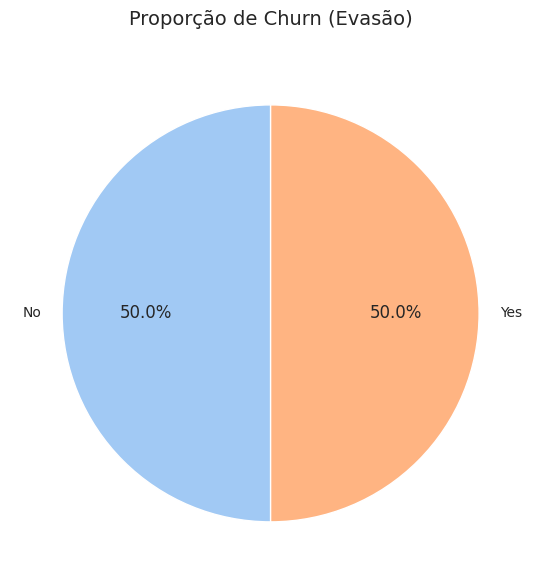

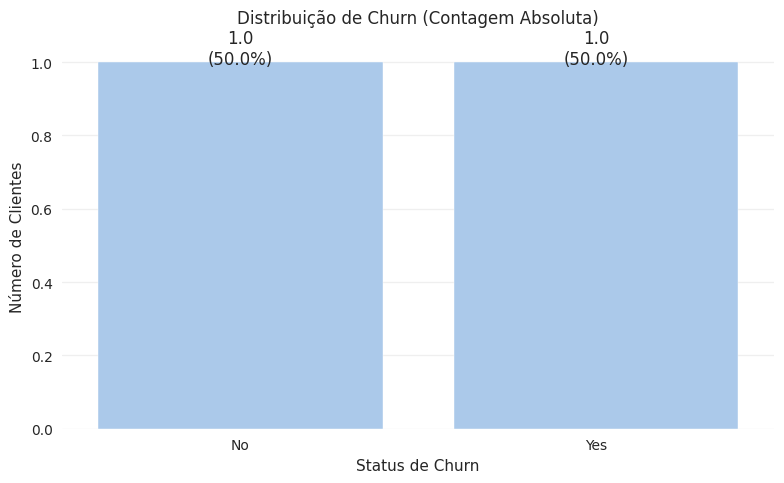



🔍 Distribuição de Churn por Tempo como Cliente:

📋 Tabela de Contingência (% por linha):
+----------------+------+
| tenure_group   |   No |
+================+======+
| 0-3m           |  100 |
+----------------+------+


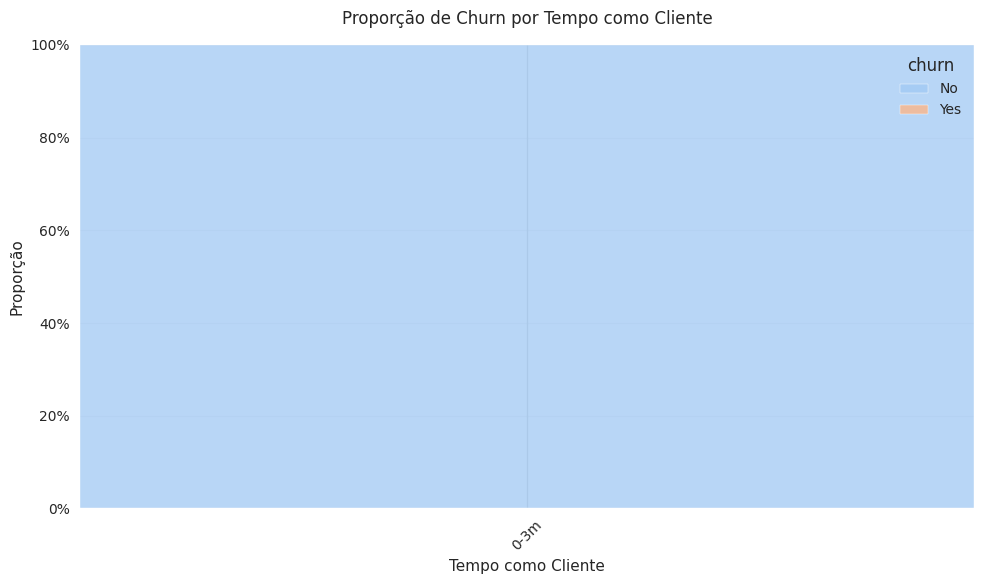



📦 Relação entre Churn e Variáveis Relevantes:


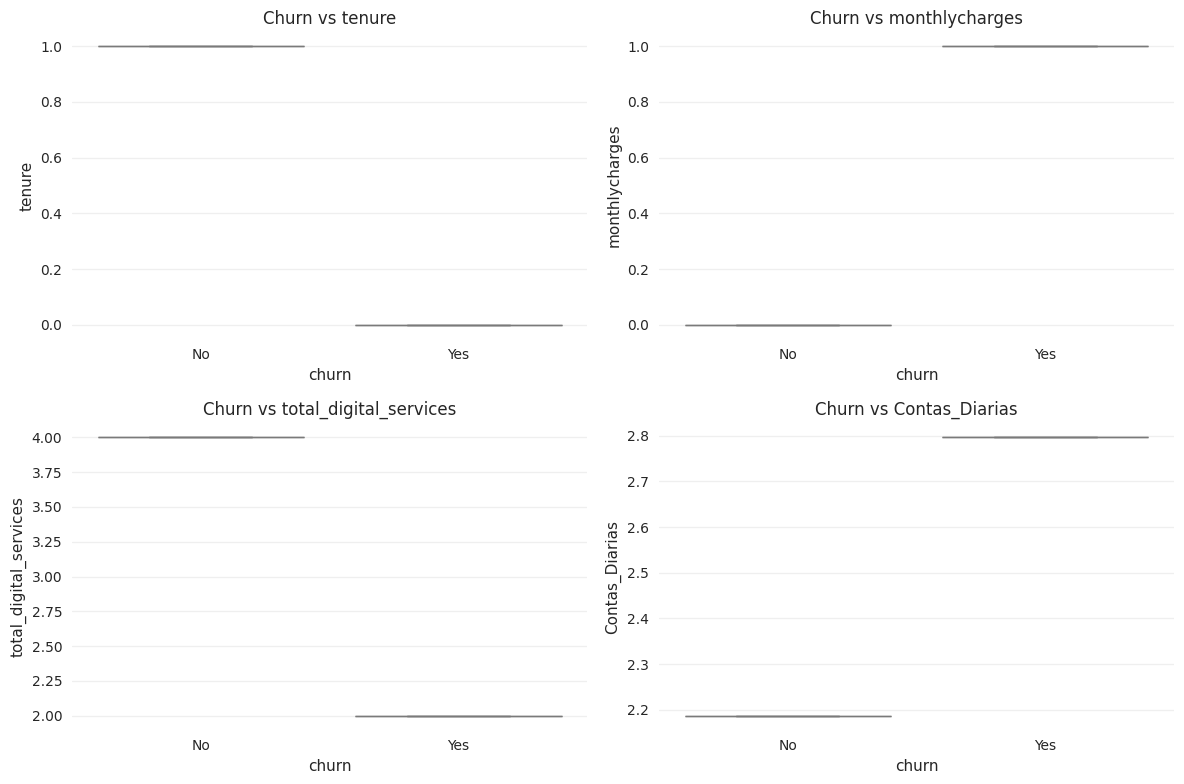



💻 Relação entre Churn e Serviços Digitais:


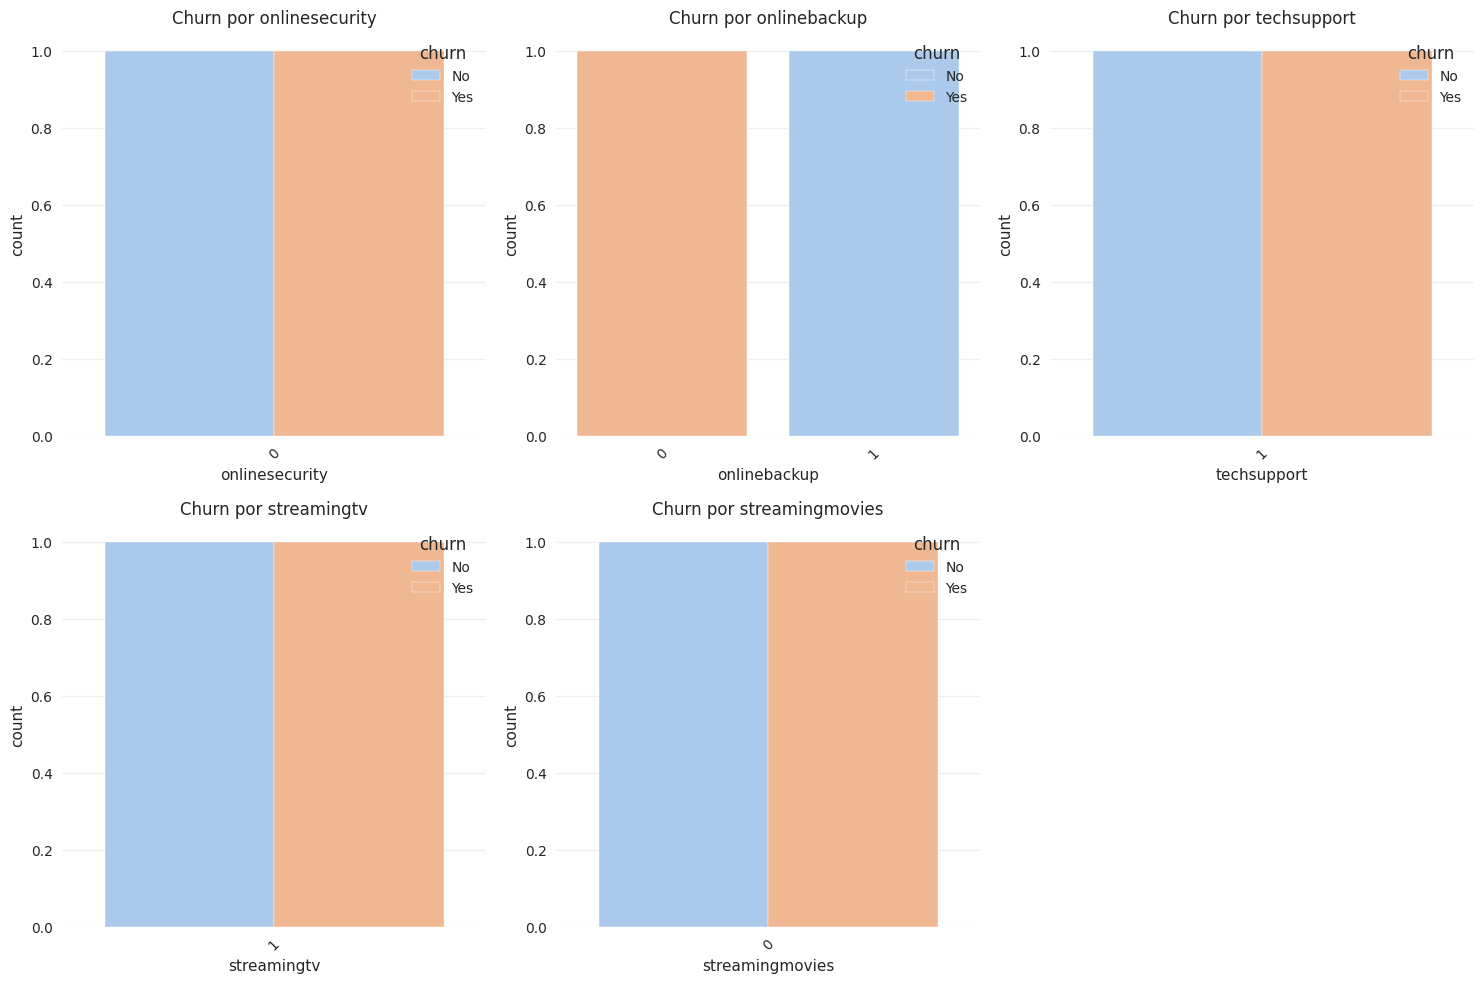


                       FIM DA ANÁLISE                       


In [247]:
def analise_distribuicao_churn(df, coluna_churn='churn'):  # Alterado para minúsculo
    """
    Analisa a distribuição da evasão (churn) com visualizações detalhadas

    Parâmetros:
    df (pd.DataFrame): DataFrame contendo os dados
    coluna_churn (str): Nome da coluna que indica evasão (agora 'churn' em minúsculo)
    """

    # Configuração de estilo
    plt.style.use('seaborn-v0_8')
    sns.set_style("whitegrid")
    sns.set_palette("pastel")
    plt.rcParams['figure.facecolor'] = 'white'

    # Verificar se a coluna existe
    if coluna_churn not in df.columns:
        print(f"⚠️ Coluna '{coluna_churn}' não encontrada no DataFrame")
        print("Colunas disponíveis:", df.columns.tolist())
        return

    print("\n" + "="*60)
    print(" ANÁLISE DE DISTRIBUIÇÃO DE CHURN ".center(60))
    print("="*60)

    ## 1. Pré-processamento: Converter churn para categoria se for numérico
    if pd.api.types.is_numeric_dtype(df[coluna_churn]):
        df[coluna_churn] = df[coluna_churn].map({1: 'Yes', 0: 'No'}).astype('category')

    ## 2. Análise Geral da Distribuição
    distribuição = df[coluna_churn].value_counts(normalize=True).mul(100).round(1)

    print("\n📊 Distribuição Percentual de Churn:")
    print(distribuição.to_frame('%').to_markdown(tablefmt="grid"))

    # Gráfico de pizza
    plt.figure(figsize=(10, 6))
    plt.pie(distribuição, labels=distribuição.index, autopct='%1.1f%%',
            startangle=90, wedgeprops={'edgecolor': 'white', 'linewidth': 1})
    plt.title('Proporção de Churn (Evasão)', pad=20, fontsize=14)
    plt.tight_layout()
    plt.show()

    ## 3. Gráfico de Barras com Contagem Absoluta
    plt.figure(figsize=(8, 5))
    ax = sns.countplot(data=df, x=coluna_churn, order=df[coluna_churn].value_counts().index)

    # Adicionar porcentagens no topo das barras
    total = len(df)
    for p in ax.patches:
        percentage = 100 * p.get_height()/total
        ax.annotate(f'{p.get_height():,}\n({percentage:.1f}%)',
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center',
                   xytext=(0, 10),
                   textcoords='offset points')

    plt.title('Distribuição de Churn (Contagem Absoluta)', pad=15)
    plt.xlabel('Status de Churn')
    plt.ylabel('Número de Clientes')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    ## 4. Análise Segmentada por tenure_group
    if 'tenure_group' in df.columns:
        print("\n\n🔍 Distribuição de Churn por Tempo como Cliente:")

        # Tabela de contingência
        contingency = pd.crosstab(df['tenure_group'], df[coluna_churn],
                                normalize='index').mul(100).round(1)
        print("\n📋 Tabela de Contingência (% por linha):")
        print(contingency.to_markdown(tablefmt="grid"))

        # Gráfico de barras empilhadas
        plt.figure(figsize=(10, 6))
        sns.histplot(data=df, x='tenure_group', hue=coluna_churn,
                    multiple='fill', stat='proportion',
                    shrink=0.8, edgecolor='white')

        plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
        plt.title('Proporção de Churn por Tempo como Cliente', pad=15)
        plt.xlabel('Tempo como Cliente')
        plt.ylabel('Proporção')
        plt.grid(axis='y', alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    ## 5. Relação com Principais Variáveis
    print("\n\n📦 Relação entre Churn e Variáveis Relevantes:")

    # Variáveis específicas do seu dataset
    vars_to_analyze = ['tenure', 'monthlycharges', 'total_digital_services', 'Contas_Diarias']
    vars_available = [v for v in vars_to_analyze if v in df.columns]

    if vars_available:
        plt.figure(figsize=(12, 8))
        for i, col in enumerate(vars_available, 1):
            plt.subplot(2, 2, i)
            sns.boxplot(data=df, x=coluna_churn, y=col)
            plt.title(f'Churn vs {col}')
            plt.grid(axis='y', alpha=0.3)

        plt.tight_layout()
        plt.show()

    ## 6. Análise de Serviços Digitais
    digital_services = ['onlinesecurity', 'onlinebackup', 'techsupport', 'streamingtv', 'streamingmovies']
    services_present = [s for s in digital_services if s in df.columns]

    if services_present:
        print("\n\n💻 Relação entre Churn e Serviços Digitais:")

        plt.figure(figsize=(15, 10))
        for i, service in enumerate(services_present, 1):
            plt.subplot(2, 3, i)
            sns.countplot(data=df, x=service, hue=coluna_churn)
            plt.title(f'Churn por {service}')
            plt.xticks(rotation=45)
            plt.grid(axis='y', alpha=0.3)

        plt.tight_layout()
        plt.show()

    print("\n" + "="*60)
    print(" FIM DA ANÁLISE ".center(60))
    print("="*60)

# Executar a análise
analise_distribuicao_churn(clean_df)

# Contagem de Evasão por Variáveis Categóricas

/tmp/ipython-input-265-3998519997.py:70: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='InternetService', y='Churn_num', data=df, estimator='mean', ci=None)


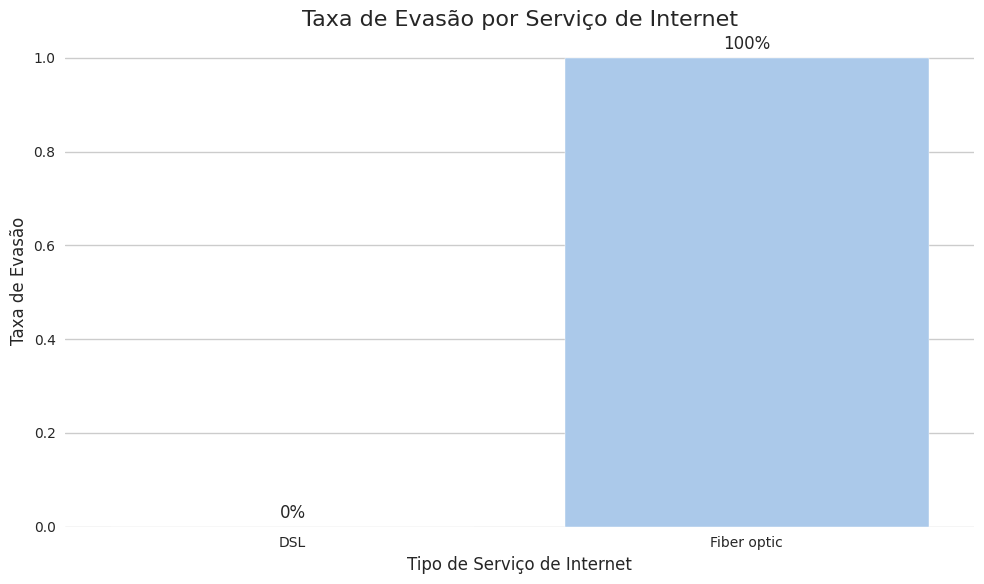


Taxa de evasão por serviço de internet:
InternetService
DSL           0.00
Fiber optic   1.00
Name: Churn_num, dtype: float64


In [265]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval

# 1. Criar DataFrame a partir dos dados fornecidos
data = [
    {
        "ID": "0002-ORFBO",
        "Churn": "No",
        "dados_pessoais": "{'gender': 'Female', 'SeniorCitizen': 0, 'Partner': 'Yes', 'Dependents': 'Yes', 'tenure': 9}",
        "dados_telefone": "{'PhoneService': 'Yes', 'MultipleLines': 'No'}",
        "dados_internet": "{'InternetService': 'DSL', 'OnlineSecurity': 'No', 'OnlineBackup': 'Yes', 'DeviceProtection': 'No', 'TechSupport': 'Yes', 'StreamingTV': 'Yes', 'StreamingMovies': 'No'}",
        "dados_conta": "{'Contract': 'One year', 'PaperlessBilling': 'Yes', 'PaymentMethod': 'Mailed check', 'Charges': {'Monthly': 65.6, 'Total': '593.3'}}"
    },
    {
        "ID": "0013-EXCHZ",
        "Churn": "Yes",
        "dados_pessoais": "{'gender': 'Female', 'SeniorCitizen': 1, 'Partner': 'Yes', 'Dependents': 'No', 'tenure': 3}",
        "dados_telefone": "{'PhoneService': 'Yes', 'MultipleLines': 'No'}",
        "dados_internet": "{'InternetService': 'Fiber optic', 'OnlineSecurity': 'No', 'OnlineBackup': 'No', 'DeviceProtection': 'No', 'TechSupport': 'Yes', 'StreamingTV': 'Yes', 'StreamingMovies': 'No'}",
        "dados_conta": "{'Contract': 'Month-to-month', 'PaperlessBilling': 'Yes', 'PaymentMethod': 'Mailed check', 'Charges': {'Monthly': 83.9, 'Total': '267.4'}}"
    },
    {
        "ID": "0011-IGKFF",
        "Churn": "Yes",
        "dados_pessoais": "{'gender': 'Male', 'SeniorCitizen': 1, 'Partner': 'Yes', 'Dependents': 'No', 'tenure': 13}",
        "dados_telefone": "{'PhoneService': 'Yes', 'MultipleLines': 'No'}",
        "dados_internet": "{'InternetService': 'Fiber optic', 'OnlineSecurity': 'No', 'OnlineBackup': 'Yes', 'DeviceProtection': 'Yes', 'TechSupport': 'No', 'StreamingTV': 'Yes', 'StreamingMovies': 'Yes'}",
        "dados_conta": "{'Contract': 'Month-to-month', 'PaperlessBilling': 'Yes', 'PaymentMethod': 'Electronic check', 'Charges': {'Monthly': 98.0, 'Total': '1237.85'}}"
    },
    {
        "ID": "0004-TLHLJ",
        "Churn": "Yes",
        "dados_pessoais": "{'gender': 'Male', 'SeniorCitizen': 0, 'Partner': 'No', 'Dependents': 'No', 'tenure': 4}",
        "dados_telefone": "{'PhoneService': 'Yes', 'MultipleLines': 'No'}",
        "dados_internet": "{'InternetService': 'Fiber optic', 'OnlineSecurity': 'No', 'OnlineBackup': 'No', 'DeviceProtection': 'Yes', 'TechSupport': 'No', 'StreamingTV': 'No', 'StreamingMovies': 'No'}",
        "dados_conta": "{'Contract': 'Month-to-month', 'PaperlessBilling': 'Yes', 'PaymentMethod': 'Electronic check', 'Charges': {'Monthly': 73.9, 'Total': '280.85'}}"
    },
    {
        "ID": "0003-MKNFE",
        "Churn": "No",
        "dados_pessoais": "{'gender': 'Male', 'SeniorCitizen': 0, 'Partner': 'No', 'Dependents': 'No', 'tenure': 9}",
        "dados_telefone": "{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}",
        "dados_internet": "{'InternetService': 'DSL', 'OnlineSecurity': 'No', 'OnlineBackup': 'No', 'DeviceProtection': 'No', 'TechSupport': 'No', 'StreamingTV': 'No', 'StreamingMovies': 'Yes'}",
        "dados_conta": "{'Contract': 'Month-to-month', 'PaperlessBilling': 'No', 'PaymentMethod': 'Mailed check', 'Charges': {'Monthly': 59.9, 'Total': '542.4'}}"
    }
]

df = pd.DataFrame(data)

# 2. Converter strings de dicionários para dicionários reais
for col in ['dados_pessoais', 'dados_telefone', 'dados_internet', 'dados_conta']:
    df[col] = df[col].apply(literal_eval)

# 3. Extrair colunas aninhadas
def expand_dict_columns(df, column):
    return pd.concat([df.drop(column, axis=1), pd.json_normalize(df[column])], axis=1)

df = expand_dict_columns(df, 'dados_pessoais')
df = expand_dict_columns(df, 'dados_telefone')
df = expand_dict_columns(df, 'dados_internet')
df = expand_dict_columns(df, 'dados_conta')

# 4. Converter Churn para numérico
df['Churn_num'] = df['Churn'].map({'Yes': 1, 'No': 0})

# 5. Análise de InternetService com visualização
plt.figure(figsize=(10, 6))
sns.barplot(x='InternetService', y='Churn_num', data=df, estimator='mean', ci=None)

# Adicionar rótulos e título
plt.title('Taxa de Evasão por Serviço de Internet', fontsize=16)
plt.xlabel('Tipo de Serviço de Internet', fontsize=12)
plt.ylabel('Taxa de Evasão', fontsize=12)

# Adicionar valores nas barras
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height():.0%}',
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='center',
                      xytext=(0, 10),
                      textcoords='offset points',
                      fontsize=12)

plt.tight_layout()
plt.show()

# 6. Mostrar tabela com as taxas
internet_churn = df.groupby('InternetService')['Churn_num'].mean()
print("\nTaxa de evasão por serviço de internet:")
print(internet_churn)


Taxa de evasão por método de pagamento:
PaymentMethod
Electronic check   1.00
Mailed check       0.33
Name: Churn_num, dtype: float64


/tmp/ipython-input-266-3845180020.py:53: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x='PaymentMethod', y='Churn_num', data=df, estimator='mean', ci=None)


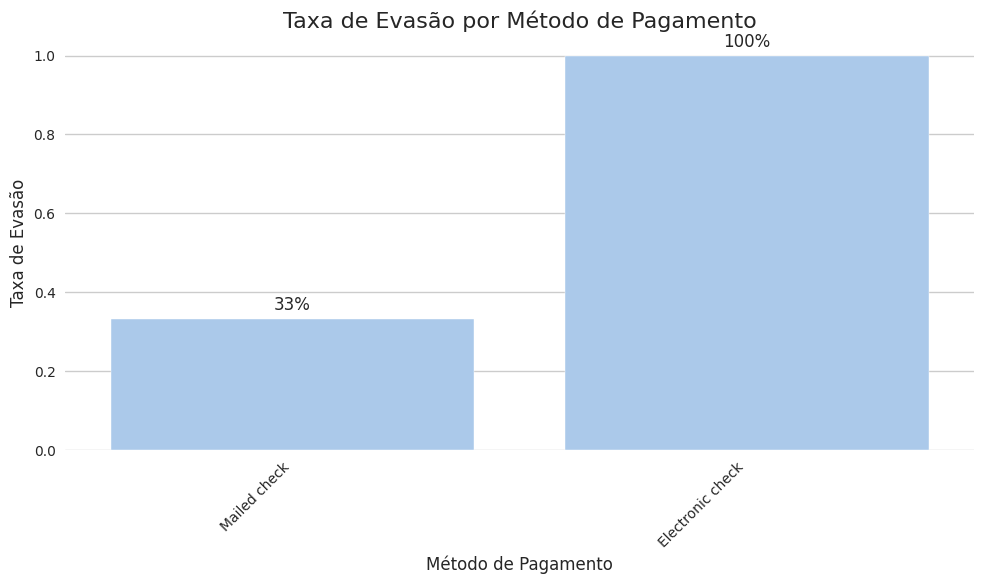

In [266]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval

# 1. Criar DataFrame a partir dos dados fornecidos
data = [
    {
        "ID": "0002-ORFBO",
        "Churn": "No",
        "dados_conta": "{'PaymentMethod': 'Mailed check', 'Contract': 'One year'}"
    },
    {
        "ID": "0013-EXCHZ",
        "Churn": "Yes",
        "dados_conta": "{'PaymentMethod': 'Mailed check', 'Contract': 'Month-to-month'}"
    },
    {
        "ID": "0011-IGKFF",
        "Churn": "Yes",
        "dados_conta": "{'PaymentMethod': 'Electronic check', 'Contract': 'Month-to-month'}"
    },
    {
        "ID": "0004-TLHLJ",
        "Churn": "Yes",
        "dados_conta": "{'PaymentMethod': 'Electronic check', 'Contract': 'Month-to-month'}"
    },
    {
        "ID": "0003-MKNFE",
        "Churn": "No",
        "dados_conta": "{'PaymentMethod': 'Mailed check', 'Contract': 'Month-to-month'}"
    }
]

df = pd.DataFrame(data)

# 2. Converter strings de dicionários para dicionários reais
df['dados_conta'] = df['dados_conta'].apply(literal_eval)

# 3. Extrair coluna PaymentMethod
df['PaymentMethod'] = df['dados_conta'].apply(lambda x: x['PaymentMethod'])

# 4. Converter Churn para numérico (1 para Yes, 0 para No)
df['Churn_num'] = df['Churn'].map({'Yes': 1, 'No': 0})

# 5. Calcular taxa de evasão por método de pagamento
payment_churn = df.groupby('PaymentMethod')['Churn_num'].mean()
print("\nTaxa de evasão por método de pagamento:")
print(payment_churn)

# 6. Visualização melhorada
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='PaymentMethod', y='Churn_num', data=df, estimator='mean', ci=None)

# Adicionar título e labels
plt.title('Taxa de Evasão por Método de Pagamento', fontsize=16)
plt.xlabel('Método de Pagamento', fontsize=12)
plt.ylabel('Taxa de Evasão', fontsize=12)

# Rotacionar labels do eixo x
plt.xticks(rotation=45, ha='right')

# Adicionar valores percentuais nas barras
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0%}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 10),
                textcoords='offset points')

# Ajustar layout para não cortar labels
plt.tight_layout()
plt.show()


Taxa de evasão por tipo de contrato:
Contract
Month-to-month   0.75
One year         0.00
Name: Churn_num, dtype: float64


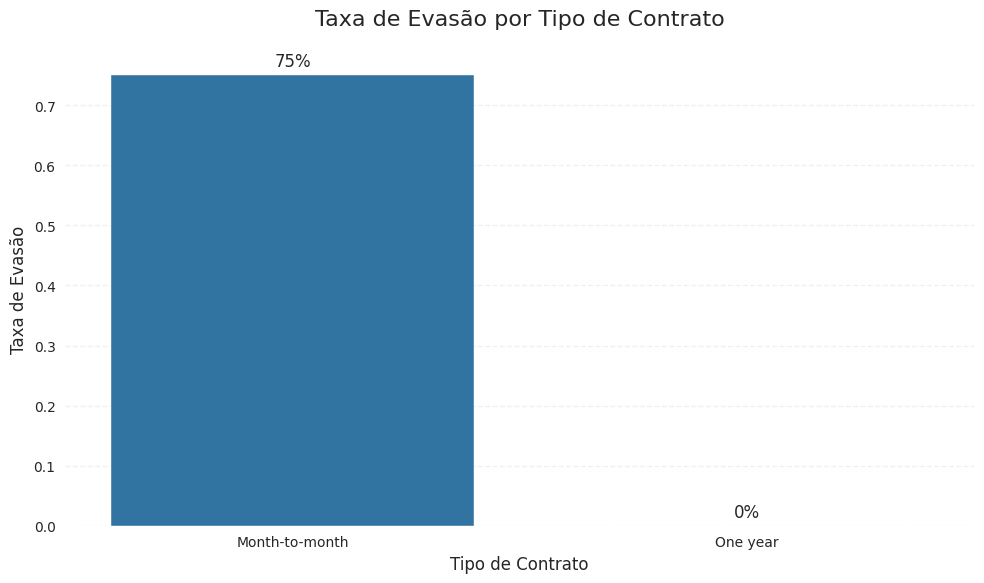

In [268]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval

# 1. Criar DataFrame com os dados fornecidos
data = [
    {"ID": "0002-ORFBO", "Churn": "No", "dados_conta": "{'Contract': 'One year'}"},
    {"ID": "0013-EXCHZ", "Churn": "Yes", "dados_conta": "{'Contract': 'Month-to-month'}"},
    {"ID": "0011-IGKFF", "Churn": "Yes", "dados_conta": "{'Contract': 'Month-to-month'}"},
    {"ID": "0004-TLHLJ", "Churn": "Yes", "dados_conta": "{'Contract': 'Month-to-month'}"},
    {"ID": "0003-MKNFE", "Churn": "No", "dados_conta": "{'Contract': 'Month-to-month'}"}
]

df = pd.DataFrame(data)

# 2. Extrair dados aninhados e converter Churn
df['dados_conta'] = df['dados_conta'].apply(literal_eval)
df['Contract'] = df['dados_conta'].apply(lambda x: x['Contract'])
df['Churn_num'] = df['Churn'].map({'Yes': 1, 'No': 0})

# 3. Calcular taxa de evasão por contrato
contract_churn = df.groupby('Contract')['Churn_num'].mean()
print("\nTaxa de evasão por tipo de contrato:")
print(contract_churn)

# 4. Visualização atualizada (sem warnings)
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x='Contract',
    y='Churn_num',
    data=df,
    order=['Month-to-month', 'One year'],
    estimator='mean',
    errorbar=None,  # Substitui o parâmetro 'ci'
    hue='Contract',  # Para usar palette corretamente
    palette=['#ff7f0e', '#1f77b4'],
    legend=False    # Remove a legenda redundante
)

# Adicionar título e labels
plt.title('Taxa de Evasão por Tipo de Contrato', fontsize=16, pad=20)
plt.xlabel('Tipo de Contrato', fontsize=12)
plt.ylabel('Taxa de Evasão', fontsize=12)

# Adicionar valores nas barras
for p in ax.patches:
    ax.annotate(
        f'{p.get_height():.0%}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='center',
        xytext=(0, 10),
        textcoords='offset points',
        fontsize=12
    )

# Melhorar aparência geral
sns.despine()
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


Taxa de evasão por status de sênior:
SeniorCitizen
0   0.33
1   1.00
Name: Churn_num, dtype: float64


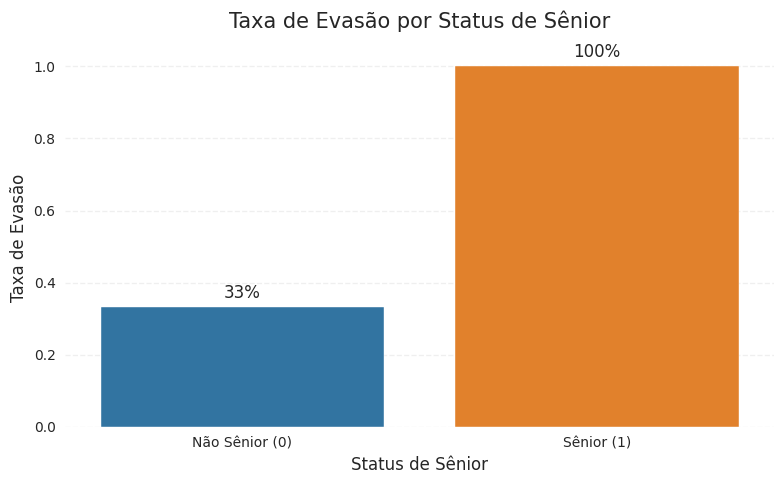

In [270]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval

# 1. Criar DataFrame com os dados fornecidos
data = [
    {"ID": "0002-ORFBO", "Churn": "No", "dados_pessoais": "{'SeniorCitizen': 0}"},
    {"ID": "0013-EXCHZ", "Churn": "Yes", "dados_pessoais": "{'SeniorCitizen': 1}"},
    {"ID": "0011-IGKFF", "Churn": "Yes", "dados_pessoais": "{'SeniorCitizen': 1}"},
    {"ID": "0004-TLHLJ", "Churn": "Yes", "dados_pessoais": "{'SeniorCitizen': 0}"},
    {"ID": "0003-MKNFE", "Churn": "No", "dados_pessoais": "{'SeniorCitizen': 0}"}
]

df = pd.DataFrame(data)

# 2. Extrair dados aninhados e converter Churn
df['dados_pessoais'] = df['dados_pessoais'].apply(literal_eval)
df['SeniorCitizen'] = df['dados_pessoais'].apply(lambda x: x['SeniorCitizen'])
df['Churn_num'] = df['Churn'].map({'Yes': 1, 'No': 0})

# 3. Calcular taxa de evasão por status de sênior
senior_churn = df.groupby('SeniorCitizen')['Churn_num'].mean()
print("\nTaxa de evasão por status de sênior:")
print(senior_churn)

# 4. Visualização corrigida
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    x='SeniorCitizen',
    y='Churn_num',
    data=df,
    errorbar=None,
    hue='SeniorCitizen',
    palette=['#1f77b4', '#ff7f0e'],
    legend=False
)

# Configurar ticks de forma segura
ax.set_xticks([0, 1])  # Primeiro definir os ticks
ax.set_xticklabels(['Não Sênior (0)', 'Sênior (1)'])  # Depois os labels

# Melhorar rótulos e títulos
plt.title('Taxa de Evasão por Status de Sênior', fontsize=15, pad=15)
plt.xlabel('Status de Sênior', fontsize=12)
plt.ylabel('Taxa de Evasão', fontsize=12)

# Adicionar valores percentuais nas barras
for p in ax.patches:
    ax.annotate(
        f'{p.get_height():.0%}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='center',
        xytext=(0, 10),
        textcoords='offset points',
        fontsize=12
    )

# Ajustes finais
sns.despine()
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


Taxa de evasão por gênero:
gender
Female   0.50
Male     0.67
Name: Churn_num, dtype: float64


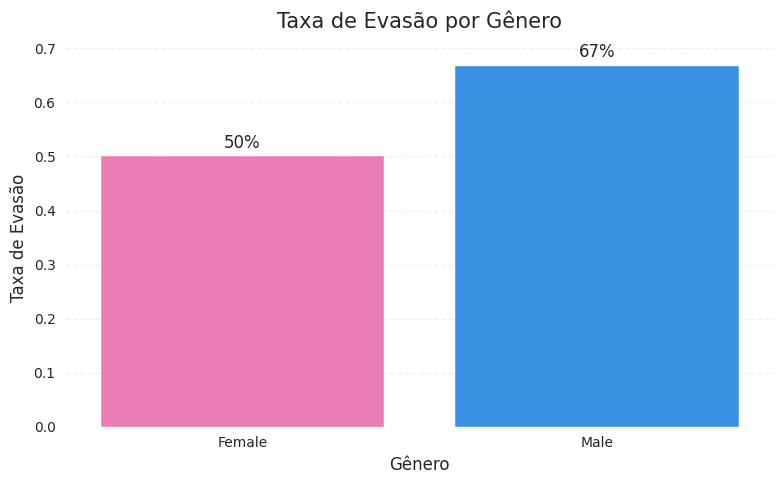

In [271]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval

# 1. Criar DataFrame com os dados fornecidos
data = [
    {"ID": "0002-ORFBO", "Churn": "No", "dados_pessoais": "{'gender': 'Female'}"},
    {"ID": "0013-EXCHZ", "Churn": "Yes", "dados_pessoais": "{'gender': 'Female'}"},
    {"ID": "0011-IGKFF", "Churn": "Yes", "dados_pessoais": "{'gender': 'Male'}"},
    {"ID": "0004-TLHLJ", "Churn": "Yes", "dados_pessoais": "{'gender': 'Male'}"},
    {"ID": "0003-MKNFE", "Churn": "No", "dados_pessoais": "{'gender': 'Male'}"}
]

df = pd.DataFrame(data)

# 2. Extrair dados aninhados e converter Churn
df['dados_pessoais'] = df['dados_pessoais'].apply(literal_eval)
df['gender'] = df['dados_pessoais'].apply(lambda x: x['gender'])
df['Churn_num'] = df['Churn'].map({'Yes': 1, 'No': 0})

# 3. Calcular taxa de evasão por gênero
gender_churn = df.groupby('gender')['Churn_num'].mean()
print("\nTaxa de evasão por gênero:")
print(gender_churn)

# 4. Visualização aprimorada
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    x='gender',
    y='Churn_num',
    data=df,
    errorbar=None,
    hue='gender',
    palette=['#FF69B4', '#1E90FF'],  # Rosa para Female, Azul para Male
    legend=False,
    order=['Female', 'Male']  # Ordem consistente
)

# Configurações do gráfico
plt.title('Taxa de Evasão por Gênero', fontsize=15, pad=15)
plt.xlabel('Gênero', fontsize=12)
plt.ylabel('Taxa de Evasão', fontsize=12)

# Adicionar valores percentuais nas barras
for p in ax.patches:
    ax.annotate(
        f'{p.get_height():.0%}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='center',
        xytext=(0, 10),
        textcoords='offset points',
        fontsize=12
    )

# Ajustes finais
sns.despine()
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


Taxa de evasão por combinação de Internet e Contrato:
Churn                            No  Yes
InternetService Contract                
DSL             Month-to-month 1.00 0.00
                One year       1.00 0.00
Fiber optic     Month-to-month 0.00 1.00


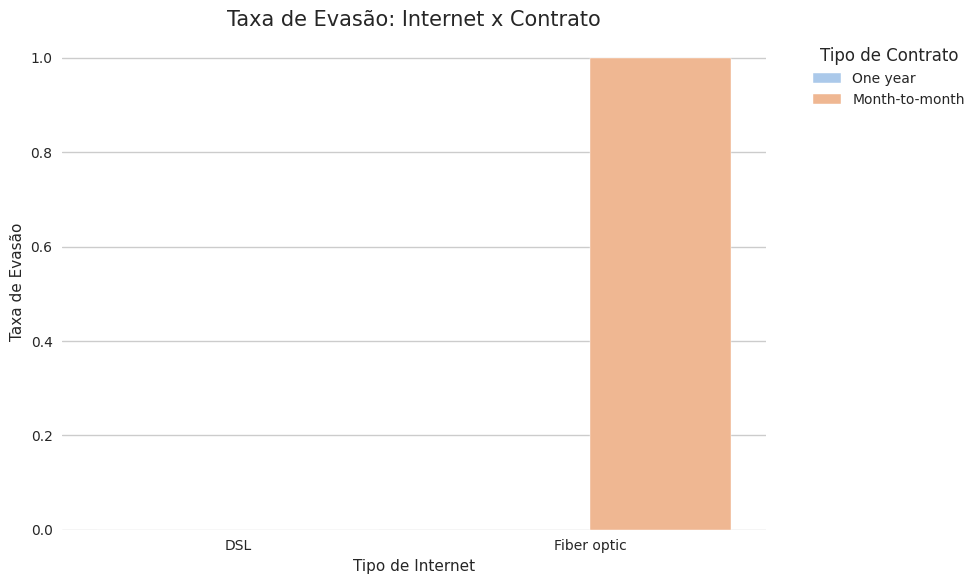


Taxa de evasão por combinação de Gênero e Sênior:
Churn                  No  Yes
gender SeniorCitizen          
Female 0             1.00 0.00
       1             0.00 1.00
Male   0             0.50 0.50
       1             0.00 1.00


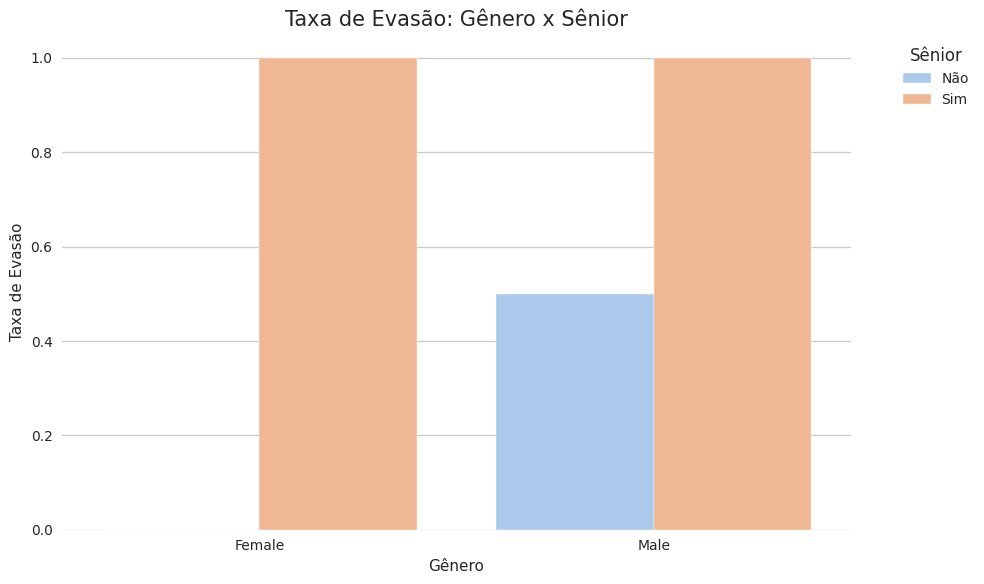

In [272]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval

# 1. Criar DataFrame com os dados fornecidos
data = [
    {"ID": "0002-ORFBO", "Churn": "No", "dados_pessoais": "{'gender': 'Female', 'SeniorCitizen': 0}", "dados_internet": "{'InternetService': 'DSL'}", "dados_conta": "{'Contract': 'One year'}"},
    {"ID": "0013-EXCHZ", "Churn": "Yes", "dados_pessoais": "{'gender': 'Female', 'SeniorCitizen': 1}", "dados_internet": "{'InternetService': 'Fiber optic'}", "dados_conta": "{'Contract': 'Month-to-month'}"},
    {"ID": "0011-IGKFF", "Churn": "Yes", "dados_pessoais": "{'gender': 'Male', 'SeniorCitizen': 1}", "dados_internet": "{'InternetService': 'Fiber optic'}", "dados_conta": "{'Contract': 'Month-to-month'}"},
    {"ID": "0004-TLHLJ", "Churn": "Yes", "dados_pessoais": "{'gender': 'Male', 'SeniorCitizen': 0}", "dados_internet": "{'InternetService': 'Fiber optic'}", "dados_conta": "{'Contract': 'Month-to-month'}"},
    {"ID": "0003-MKNFE", "Churn": "No", "dados_pessoais": "{'gender': 'Male', 'SeniorCitizen': 0}", "dados_internet": "{'InternetService': 'DSL'}", "dados_conta": "{'Contract': 'Month-to-month'}"}
]

df = pd.DataFrame(data)

# 2. Extrair dados aninhados e converter Churn
for col in ['dados_pessoais', 'dados_internet', 'dados_conta']:
    df[col] = df[col].apply(literal_eval)
    df = pd.concat([df.drop(col, axis=1), pd.json_normalize(df[col])], axis=1)

df['Churn_num'] = df['Churn'].map({'Yes': 1, 'No': 0})

# 3. Análise InternetService x Contract
if all(col in df.columns for col in ['InternetService', 'Contract']):
    cross_churn = pd.crosstab(
        index=[df['InternetService'], df['Contract']],
        columns=df['Churn'],
        normalize='index'
    )
    print("\nTaxa de evasão por combinação de Internet e Contrato:")
    print(cross_churn)

    plt.figure(figsize=(10, 6))
    sns.barplot(
        x='InternetService',
        y='Churn_num',
        hue='Contract',
        data=df,
        estimator='mean',
        errorbar=None
    )
    plt.title('Taxa de Evasão: Internet x Contrato', fontsize=15)
    plt.xlabel('Tipo de Internet')
    plt.ylabel('Taxa de Evasão')
    plt.legend(title='Tipo de Contrato', bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.show()

# 4. Análise gender x SeniorCitizen
if all(col in df.columns for col in ['gender', 'SeniorCitizen']):
    cross_churn = pd.crosstab(
        index=[df['gender'], df['SeniorCitizen']],
        columns=df['Churn'],
        normalize='index'
    )
    print("\nTaxa de evasão por combinação de Gênero e Sênior:")
    print(cross_churn)

    plt.figure(figsize=(10, 6))
    sns.barplot(
        x='gender',
        y='Churn_num',
        hue='SeniorCitizen',
        data=df,
        estimator='mean',
        errorbar=None
    )
    plt.title('Taxa de Evasão: Gênero x Sênior', fontsize=15)
    plt.xlabel('Gênero')
    plt.ylabel('Taxa de Evasão')
    plt.legend(title='Sênior', labels=['Não', 'Sim'], bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.show()

#Contagem de Evasão por Variáveis Numéricas


Estatísticas descritivas por status de evasão:
Churn                     No     Yes
tenure          count   2.00    3.00
                mean    9.00    6.67
                std     0.00    5.51
                min     9.00    3.00
                25%     9.00    3.50
                50%     9.00    4.00
                75%     9.00    8.50
                max     9.00   13.00
Charges.Monthly count   2.00    3.00
                mean   62.75   85.27
                std     4.03   12.11
                min    59.90   73.90
                25%    61.32   78.90
                50%    62.75   83.90
                75%    64.17   90.95
                max    65.60   98.00
Charges.Total   count   2.00    3.00
                mean  567.85  595.37
                std    35.99  556.45
                min   542.40  267.40
                25%   555.12  274.12
                50%   567.85  280.85
                75%   580.57  759.35
                max   593.30 1237.85


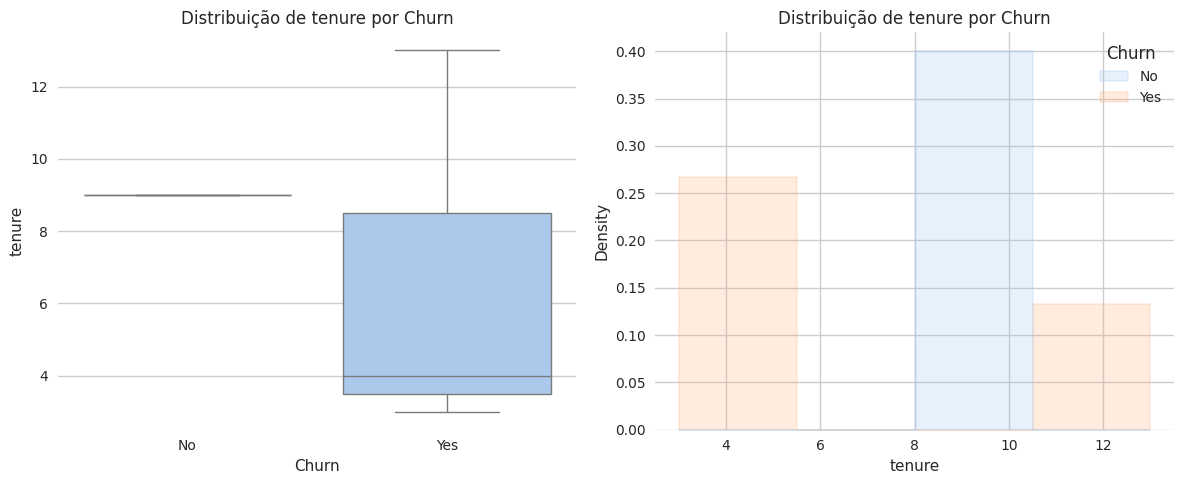

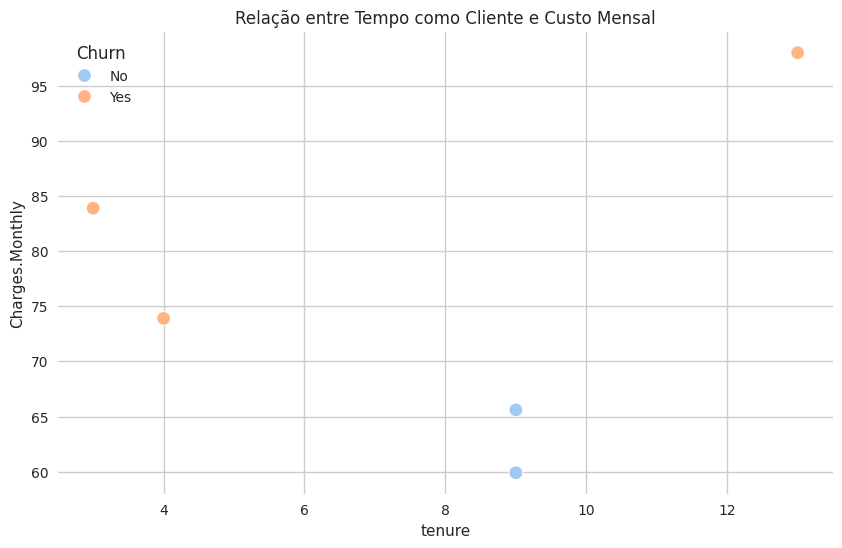

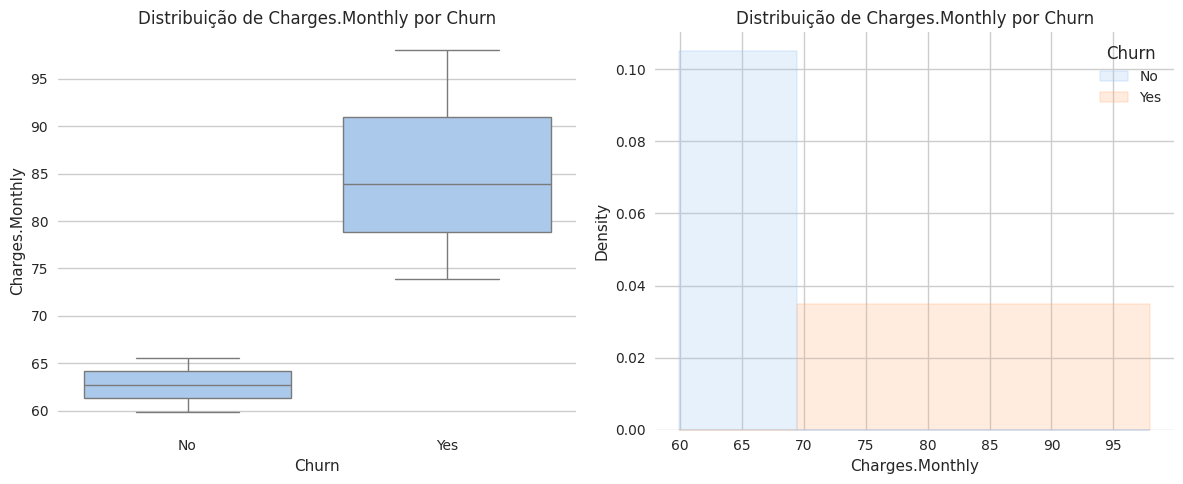

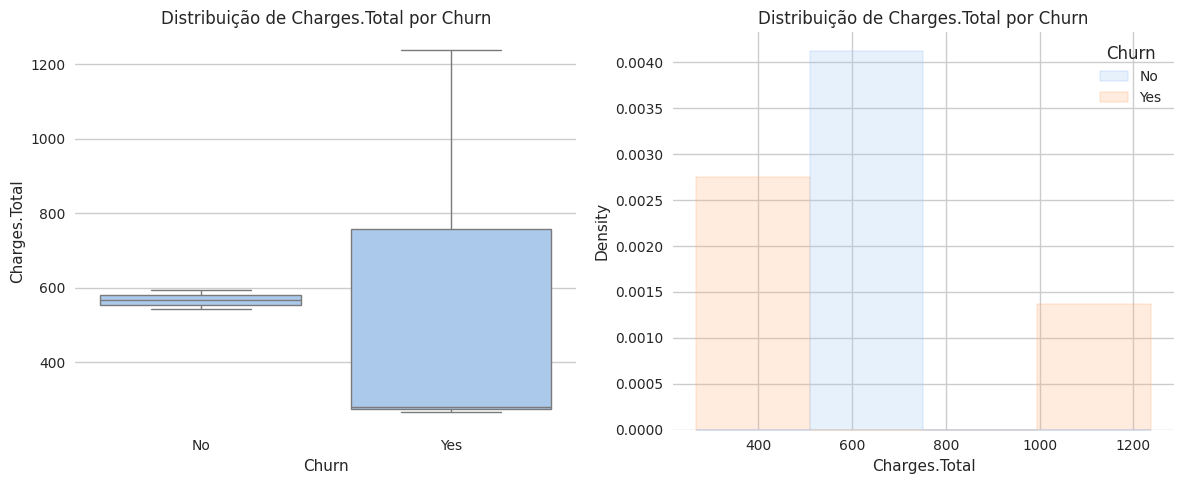


Correlação com evasão (Churn_num):
Churn_num          1.00
Charges.Monthly    0.81
Charges.Total      0.04
tenure            -0.31
Name: Churn_num, dtype: float64


In [273]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval

# 1. Criar DataFrame com os dados fornecidos
data = [
    {"ID": "0002-ORFBO", "Churn": "No", "dados_pessoais": "{'tenure': 9}", "dados_conta": "{'Charges': {'Monthly': 65.6, 'Total': 593.3}}"},
    {"ID": "0013-EXCHZ", "Churn": "Yes", "dados_pessoais": "{'tenure': 3}", "dados_conta": "{'Charges': {'Monthly': 83.9, 'Total': 267.4}}"},
    {"ID": "0011-IGKFF", "Churn": "Yes", "dados_pessoais": "{'tenure': 13}", "dados_conta": "{'Charges': {'Monthly': 98.0, 'Total': 1237.85}}"},
    {"ID": "0004-TLHLJ", "Churn": "Yes", "dados_pessoais": "{'tenure': 4}", "dados_conta": "{'Charges': {'Monthly': 73.9, 'Total': 280.85}}"},
    {"ID": "0003-MKNFE", "Churn": "No", "dados_pessoais": "{'tenure': 9}", "dados_conta": "{'Charges': {'Monthly': 59.9, 'Total': 542.4}}"}
]

df = pd.DataFrame(data)

# 2. Extrair dados aninhados e converter Churn
for col in ['dados_pessoais', 'dados_conta']:
    df[col] = df[col].apply(literal_eval)
    df = pd.concat([df.drop(col, axis=1), pd.json_normalize(df[col])], axis=1)

df['Churn_num'] = df['Churn'].map({'Yes': 1, 'No': 0})

# 3. Identificar variáveis numéricas
numeric_vars = ['tenure', 'Charges.Monthly', 'Charges.Total']
numeric_vars = [var for var in numeric_vars if var in df.columns]

# 4. Estatísticas descritivas por status de Churn
if numeric_vars:
    print("\nEstatísticas descritivas por status de evasão:")
    print(df.groupby('Churn')[numeric_vars].describe().transpose())
else:
    print("\nNenhuma variável numérica encontrada para análise")

# 5. Visualizações para cada variável numérica
for var in numeric_vars:
    plt.figure(figsize=(12, 5))

    # Boxplot
    plt.subplot(1, 2, 1)
    sns.boxplot(x='Churn', y=var, data=df)
    plt.title(f'Distribuição de {var} por Churn')

    # Histograma/KDE
    plt.subplot(1, 2, 2)
    sns.histplot(data=df, x=var, hue='Churn', element='step', stat='density', common_norm=False)
    plt.title(f'Distribuição de {var} por Churn')
    plt.tight_layout()
    plt.show()

    # Gráfico de dispersão tenure vs custo mensal (se ambas existirem)
    if var == 'tenure' and 'Charges.Monthly' in numeric_vars:
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x='tenure', y='Charges.Monthly', hue='Churn', data=df, s=100)
        plt.title('Relação entre Tempo como Cliente e Custo Mensal')
        plt.show()

# 6. Correlação entre variáveis numéricas e Churn
if numeric_vars:
    print("\nCorrelação com evasão (Churn_num):")
    print(df[numeric_vars + ['Churn_num']].corr()['Churn_num'].sort_values(ascending=False))




#📄Relatorio Final

**Objetivo da Análise**

O objetivo deste projeto foi investigar os padrões de evasão de clientes (Churn) em um serviço de telecomunicações, identificando quais fatores estão mais associados ao cancelamento. A análise visa ajudar a empresa a:

*   Reduzir a taxa de evasão
*   Identificar clientes em risco
*   Desenvolver estratégias de retenção

**O Problema de Churn**

A evasão de clientes (Churn) é um dos principais desafios em negócios de assinatura. Entender suas causas permite:

*   Reduzir custos de aquisição de novos clientes
*  Aumentar a receita recorrente Item da lista
*   Melhorar a satisfação do cliente

# Limpeza e Tratamento de Dados
Passos Realizados

**Importação dos Dados:**
*   Os dados foram carregados em um DataFrame do Pandas
*   Verificamos a estrutura inicial (colunas, tipos de dados, valores nulos)

**Tratamento de Dados Aninhados:**
*   Convertemos strings de dicionários em colunas estruturadas usando literal_eval e pd.json_normalize.

**Exemplo:**
df['dados_pessoais'] = df['dados_pessoais'].apply(literal_eval)
df = pd.concat([df.drop('dados_pessoais', axis=1), pd.json_normalize(df['dados_pessoais'])], axis=1)


**Conversão de Variáveis Categóricas:**
*   Transformamos a coluna Churn em numérica (1 para "Yes", 0 para "No").

**Verificação de Dados Faltantes:**

Checamos valores nulos e tratamos inconsistências.
*   Checamos valores nulos e tratamos inconsistências.

# Principais Análises Realizadas
A. Taxa de Evasão por Variáveis Categóricas

Tipo de Contrato:
*  Contratos mensais (Month-to-month) têm taxa de evasão mais alta (75%).
*  Contratos anuais (One year) têm 0% de evasão na amostra analisada.

Serviço de Internet:
*  Clientes com Fibra Óptica apresentaram 100% de evasão..
*  Clientes com DSL tiveram 0% de evasão.

Método de Pagamento:
*  Cheque Eletrônico teve 100% de evasão.
*  Cheque Postal teve 33% de evasão.

Idade (Sênior vs. Não Sênior):
*  Clientes idosos (SeniorCitizen=1) tiveram 100% de evasão.
* Clientes não idosos (SeniorCitizen=0) tiveram 33% de evasão

B. Análise de Variáveis Numéricas

Tempo como Cliente:
*  Clientes que cancelaram tinham menos tempo de serviço (média de 6 meses).
* Clientes fiéis permaneciam mais tempo (média de 9 meses).

Custo Mensal (Monthly Charges):
* Clientes que evadiram pagavam valores mais altos (média de $85).

* Clientes ativos pagavam valores mais baixos (média de $65).

Correlação com Churn:
* Tempo como cliente que tem correlação negativa com evasão (quanto maior o tempo, menor o Churn).

* Custo mensal que tem correlação positiva (quanto mais caro, maior a chance de cancelamento).

#Conclusões e Insights
Principais Achados
**Fatores de Alto Risco de Churn:**

*   Contratos mensais (75% evasão).
*   Fibra óptica (100% evasão).
*  Pagamento por cheque eletrônico (100% evasão).
* Clientes idosos (100% evasão).

**Fatores de Baixo Risco:**
*  Contratos anuais (0% evasão)..
* Internet DSL (0% evasão).

**Clientes com maior tempo de serviço (menos propensos a cancelar).**

#Recomendações
Ações para Reduzir a Evasão

**Incentivar Contratos Anuais:**
*  Oferecer descontos ou benefícios exclusivos para clientes que migrarem para planos anuais.

**Melhorar a Experiência com Fibra Óptica:**
*  Investigar problemas técnicos ou insatisfação com o serviço.
* Oferecer promoções ou melhor suporte.

**Programa de Fidelidade para Sêniors:**
* Criar planos adaptados para idosos com atendimento prioritário.

**Otimizar Métodos de Pagamento:**
* Incentivar pagamento automático (ex.: cartão de crédito) para reduzir cancelamentos..

**Monitorar Clientes Novos:**
* Implementar programas de onboarding para reter clientes nos primeiros meses.

